In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch
import gc

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


True


## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [2]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [3]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load(
#    '../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt'
)['hyper_parameters']['genes']

In [4]:
CELLTYPES = [
"fibroblast",
"endothelial cell",
"myofibroblast cell",
"glial cell",
"pericyte",
"lymphocyte",
"stromal cell",
]
NUM_GENES = 5000
MAXCELLS = 1024

In [5]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
adata = sc.read_h5ad('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 23061 × 70116
    obs: 'biosample_id', 'n_genes', 'n_counts', 'Type', 'donor_id', 'Layer', 'Celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'age group', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'cell_culture'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbo

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<02:41,  1.26it/s]


  1%|          | 2/205 [00:01<01:35,  2.13it/s]


  1%|▏         | 3/205 [00:01<01:14,  2.73it/s]


  2%|▏         | 4/205 [00:01<01:04,  3.14it/s]


  2%|▏         | 5/205 [00:01<00:58,  3.43it/s]


  3%|▎         | 6/205 [00:02<00:54,  3.63it/s]


  3%|▎         | 7/205 [00:02<00:52,  3.77it/s]


  4%|▍         | 8/205 [00:02<00:51,  3.86it/s]


  4%|▍         | 9/205 [00:02<00:49,  3.93it/s]


  5%|▍         | 10/205 [00:02<00:49,  3.98it/s]


  5%|▌         | 11/205 [00:03<00:48,  4.01it/s]


  6%|▌         | 12/205 [00:03<00:47,  4.04it/s]


  6%|▋         | 13/205 [00:03<00:47,  4.05it/s]


  7%|▋         | 14/205 [00:03<00:46,  4.07it/s]


  7%|▋         | 15/205 [00:04<00:46,  4.07it/s]


  8%|▊         | 16/205 [00:04<00:46,  4.08it/s]


  8%|▊         | 17/205 [00:04<00:46,  4.08it/s]


  9%|▉         | 18/205 [00:04<00:45,  4.09it/s]


  9%|▉         | 19/205 [00:05<00:45,  4.09it/s]


 10%|▉         | 20/205 [00:05<00:45,  4.09it/s]


 10%|█         | 21/205 [00:05<00:44,  4.09it/s]


 11%|█         | 22/205 [00:05<00:44,  4.09it/s]


 11%|█         | 23/205 [00:06<00:44,  4.09it/s]


 12%|█▏        | 24/205 [00:06<00:44,  4.10it/s]


 12%|█▏        | 25/205 [00:06<00:43,  4.10it/s]


 13%|█▎        | 26/205 [00:06<00:43,  4.10it/s]


 13%|█▎        | 27/205 [00:07<00:43,  4.10it/s]


 14%|█▎        | 28/205 [00:07<00:43,  4.10it/s]


 14%|█▍        | 29/205 [00:07<00:42,  4.10it/s]


 15%|█▍        | 30/205 [00:07<00:42,  4.10it/s]


 15%|█▌        | 31/205 [00:08<00:42,  4.10it/s]


 16%|█▌        | 32/205 [00:08<00:42,  4.10it/s]


 16%|█▌        | 33/205 [00:08<00:41,  4.10it/s]


 17%|█▋        | 34/205 [00:08<00:41,  4.10it/s]


 17%|█▋        | 35/205 [00:09<00:41,  4.10it/s]


 18%|█▊        | 36/205 [00:09<00:41,  4.10it/s]


 18%|█▊        | 37/205 [00:09<00:40,  4.10it/s]


 19%|█▊        | 38/205 [00:09<00:40,  4.10it/s]


 19%|█▉        | 39/205 [00:10<00:40,  4.10it/s]


 20%|█▉        | 40/205 [00:10<00:40,  4.10it/s]


 20%|██        | 41/205 [00:10<00:39,  4.10it/s]


 20%|██        | 42/205 [00:10<00:39,  4.10it/s]


 21%|██        | 43/205 [00:11<00:39,  4.10it/s]


 21%|██▏       | 44/205 [00:11<00:39,  4.10it/s]


 22%|██▏       | 45/205 [00:11<00:39,  4.10it/s]


 22%|██▏       | 46/205 [00:11<00:38,  4.10it/s]


 23%|██▎       | 47/205 [00:12<00:38,  4.10it/s]


 23%|██▎       | 48/205 [00:12<00:38,  4.10it/s]


 24%|██▍       | 49/205 [00:12<00:38,  4.10it/s]


 24%|██▍       | 50/205 [00:12<00:37,  4.10it/s]


 25%|██▍       | 51/205 [00:12<00:37,  4.10it/s]


 25%|██▌       | 52/205 [00:13<00:37,  4.10it/s]


 26%|██▌       | 53/205 [00:13<00:37,  4.10it/s]


 26%|██▋       | 54/205 [00:13<00:36,  4.10it/s]


 27%|██▋       | 55/205 [00:13<00:36,  4.10it/s]


 27%|██▋       | 56/205 [00:14<00:36,  4.10it/s]


 28%|██▊       | 57/205 [00:14<00:36,  4.10it/s]


 28%|██▊       | 58/205 [00:14<00:35,  4.10it/s]


 29%|██▉       | 59/205 [00:14<00:35,  4.10it/s]


 29%|██▉       | 60/205 [00:15<00:35,  4.10it/s]


 30%|██▉       | 61/205 [00:15<00:35,  4.10it/s]


 30%|███       | 62/205 [00:15<00:34,  4.10it/s]


 31%|███       | 63/205 [00:15<00:34,  4.09it/s]


 31%|███       | 64/205 [00:16<00:34,  4.08it/s]


 32%|███▏      | 65/205 [00:16<00:34,  4.09it/s]


 32%|███▏      | 66/205 [00:16<00:33,  4.09it/s]


 33%|███▎      | 67/205 [00:16<00:33,  4.09it/s]


 33%|███▎      | 68/205 [00:17<00:33,  4.09it/s]


 34%|███▎      | 69/205 [00:17<00:33,  4.09it/s]


 34%|███▍      | 70/205 [00:17<00:32,  4.09it/s]


 35%|███▍      | 71/205 [00:17<00:32,  4.09it/s]


 35%|███▌      | 72/205 [00:18<00:32,  4.09it/s]


 36%|███▌      | 73/205 [00:18<00:32,  4.09it/s]


 36%|███▌      | 74/205 [00:18<00:32,  4.09it/s]


 37%|███▋      | 75/205 [00:18<00:31,  4.08it/s]


 37%|███▋      | 76/205 [00:19<00:31,  4.09it/s]


 38%|███▊      | 77/205 [00:19<00:31,  4.09it/s]


 38%|███▊      | 78/205 [00:19<00:31,  4.09it/s]


 39%|███▊      | 79/205 [00:19<00:30,  4.09it/s]


 39%|███▉      | 80/205 [00:20<00:30,  4.09it/s]


 40%|███▉      | 81/205 [00:20<00:30,  4.09it/s]


 40%|████      | 82/205 [00:20<00:30,  4.09it/s]


 40%|████      | 83/205 [00:20<00:29,  4.09it/s]


 41%|████      | 84/205 [00:21<00:29,  4.09it/s]


 41%|████▏     | 85/205 [00:21<00:29,  4.09it/s]


 42%|████▏     | 86/205 [00:21<00:29,  4.09it/s]


 42%|████▏     | 87/205 [00:21<00:28,  4.09it/s]


 43%|████▎     | 88/205 [00:22<00:28,  4.09it/s]


 43%|████▎     | 89/205 [00:22<00:28,  4.09it/s]


 44%|████▍     | 90/205 [00:22<00:28,  4.09it/s]


 44%|████▍     | 91/205 [00:22<00:27,  4.09it/s]


 45%|████▍     | 92/205 [00:23<00:27,  4.09it/s]


 45%|████▌     | 93/205 [00:23<00:27,  4.09it/s]


 46%|████▌     | 94/205 [00:23<00:27,  4.09it/s]


 46%|████▋     | 95/205 [00:23<00:26,  4.09it/s]


 47%|████▋     | 96/205 [00:23<00:26,  4.10it/s]


 47%|████▋     | 97/205 [00:24<00:26,  4.10it/s]


 48%|████▊     | 98/205 [00:24<00:26,  4.10it/s]


 48%|████▊     | 99/205 [00:24<00:25,  4.09it/s]


 49%|████▉     | 100/205 [00:24<00:25,  4.10it/s]


 49%|████▉     | 101/205 [00:25<00:25,  4.09it/s]


 50%|████▉     | 102/205 [00:25<00:25,  4.09it/s]


 50%|█████     | 103/205 [00:25<00:24,  4.09it/s]


 51%|█████     | 104/205 [00:25<00:24,  4.10it/s]


 51%|█████     | 105/205 [00:26<00:24,  4.10it/s]


 52%|█████▏    | 106/205 [00:26<00:24,  4.10it/s]


 52%|█████▏    | 107/205 [00:26<00:23,  4.10it/s]


 53%|█████▎    | 108/205 [00:26<00:23,  4.10it/s]


 53%|█████▎    | 109/205 [00:27<00:23,  4.09it/s]


 54%|█████▎    | 110/205 [00:27<00:23,  4.10it/s]


 54%|█████▍    | 111/205 [00:27<00:22,  4.10it/s]


 55%|█████▍    | 112/205 [00:27<00:22,  4.09it/s]


 55%|█████▌    | 113/205 [00:28<00:22,  4.09it/s]


 56%|█████▌    | 114/205 [00:28<00:22,  4.09it/s]


 56%|█████▌    | 115/205 [00:28<00:21,  4.10it/s]


 57%|█████▋    | 116/205 [00:28<00:21,  4.10it/s]


 57%|█████▋    | 117/205 [00:29<00:21,  4.09it/s]


 58%|█████▊    | 118/205 [00:29<00:21,  4.10it/s]


 58%|█████▊    | 119/205 [00:29<00:21,  4.09it/s]


 59%|█████▊    | 120/205 [00:29<00:20,  4.10it/s]


 59%|█████▉    | 121/205 [00:30<00:20,  4.09it/s]


 60%|█████▉    | 122/205 [00:30<00:20,  4.09it/s]


 60%|██████    | 123/205 [00:30<00:20,  4.09it/s]


 60%|██████    | 124/205 [00:30<00:19,  4.09it/s]


 61%|██████    | 125/205 [00:31<00:19,  4.09it/s]


 61%|██████▏   | 126/205 [00:31<00:19,  4.09it/s]


 62%|██████▏   | 127/205 [00:31<00:19,  4.09it/s]


 62%|██████▏   | 128/205 [00:31<00:18,  4.09it/s]


 63%|██████▎   | 129/205 [00:32<00:18,  4.09it/s]


 63%|██████▎   | 130/205 [00:32<00:18,  4.09it/s]


 64%|██████▍   | 131/205 [00:32<00:18,  4.09it/s]


 64%|██████▍   | 132/205 [00:32<00:17,  4.09it/s]


 65%|██████▍   | 133/205 [00:33<00:17,  4.10it/s]


 65%|██████▌   | 134/205 [00:33<00:17,  4.10it/s]


 66%|██████▌   | 135/205 [00:33<00:17,  4.10it/s]


 66%|██████▋   | 136/205 [00:33<00:16,  4.10it/s]


 67%|██████▋   | 137/205 [00:34<00:16,  4.10it/s]


 67%|██████▋   | 138/205 [00:34<00:16,  4.10it/s]


 68%|██████▊   | 139/205 [00:34<00:16,  4.10it/s]


 68%|██████▊   | 140/205 [00:34<00:15,  4.10it/s]


 69%|██████▉   | 141/205 [00:34<00:15,  4.09it/s]


 69%|██████▉   | 142/205 [00:35<00:15,  4.09it/s]


 70%|██████▉   | 143/205 [00:35<00:15,  4.10it/s]


 70%|███████   | 144/205 [00:35<00:14,  4.09it/s]


 71%|███████   | 145/205 [00:35<00:14,  4.09it/s]


 71%|███████   | 146/205 [00:36<00:14,  4.10it/s]


 72%|███████▏  | 147/205 [00:36<00:14,  4.09it/s]


 72%|███████▏  | 148/205 [00:36<00:13,  4.09it/s]


 73%|███████▎  | 149/205 [00:36<00:13,  4.09it/s]


 73%|███████▎  | 150/205 [00:37<00:13,  4.09it/s]


 74%|███████▎  | 151/205 [00:37<00:13,  4.09it/s]


 74%|███████▍  | 152/205 [00:37<00:12,  4.10it/s]


 75%|███████▍  | 153/205 [00:37<00:12,  4.09it/s]


 75%|███████▌  | 154/205 [00:38<00:12,  4.09it/s]


 76%|███████▌  | 155/205 [00:38<00:12,  4.09it/s]


 76%|███████▌  | 156/205 [00:38<00:11,  4.10it/s]


 77%|███████▋  | 157/205 [00:38<00:11,  4.10it/s]


 77%|███████▋  | 158/205 [00:39<00:11,  4.09it/s]


 78%|███████▊  | 159/205 [00:39<00:11,  4.09it/s]


 78%|███████▊  | 160/205 [00:39<00:10,  4.09it/s]


 79%|███████▊  | 161/205 [00:39<00:10,  4.09it/s]


 79%|███████▉  | 162/205 [00:40<00:10,  4.09it/s]


 80%|███████▉  | 163/205 [00:40<00:10,  4.09it/s]


 80%|████████  | 164/205 [00:40<00:10,  4.09it/s]


 80%|████████  | 165/205 [00:40<00:09,  4.09it/s]


 81%|████████  | 166/205 [00:41<00:09,  4.09it/s]


 81%|████████▏ | 167/205 [00:41<00:09,  4.09it/s]


 82%|████████▏ | 168/205 [00:41<00:09,  4.09it/s]


 82%|████████▏ | 169/205 [00:41<00:08,  4.09it/s]


 83%|████████▎ | 170/205 [00:42<00:08,  4.09it/s]


 83%|████████▎ | 171/205 [00:42<00:08,  4.09it/s]


 84%|████████▍ | 172/205 [00:42<00:08,  4.09it/s]


 84%|████████▍ | 173/205 [00:42<00:07,  4.09it/s]


 85%|████████▍ | 174/205 [00:43<00:07,  4.09it/s]


 85%|████████▌ | 175/205 [00:43<00:07,  4.09it/s]


 86%|████████▌ | 176/205 [00:43<00:07,  4.09it/s]


 86%|████████▋ | 177/205 [00:43<00:06,  4.09it/s]


 87%|████████▋ | 178/205 [00:44<00:06,  4.09it/s]


 87%|████████▋ | 179/205 [00:44<00:06,  4.09it/s]


 88%|████████▊ | 180/205 [00:44<00:06,  4.09it/s]


 88%|████████▊ | 181/205 [00:44<00:05,  4.08it/s]


 89%|████████▉ | 182/205 [00:45<00:05,  4.08it/s]


 89%|████████▉ | 183/205 [00:45<00:05,  4.08it/s]


 90%|████████▉ | 184/205 [00:45<00:05,  4.08it/s]


 90%|█████████ | 185/205 [00:45<00:04,  4.09it/s]


 91%|█████████ | 186/205 [00:45<00:04,  4.09it/s]


 91%|█████████ | 187/205 [00:46<00:04,  4.08it/s]


 92%|█████████▏| 188/205 [00:46<00:04,  4.09it/s]


 92%|█████████▏| 189/205 [00:46<00:03,  4.09it/s]


 93%|█████████▎| 190/205 [00:46<00:03,  4.09it/s]


 93%|█████████▎| 191/205 [00:47<00:03,  4.09it/s]


 94%|█████████▎| 192/205 [00:47<00:03,  4.09it/s]


 94%|█████████▍| 193/205 [00:47<00:02,  4.08it/s]


 95%|█████████▍| 194/205 [00:47<00:02,  4.09it/s]


 95%|█████████▌| 195/205 [00:48<00:02,  4.09it/s]


 96%|█████████▌| 196/205 [00:48<00:02,  4.09it/s]


 96%|█████████▌| 197/205 [00:48<00:01,  4.09it/s]


 97%|█████████▋| 198/205 [00:48<00:01,  4.09it/s]


 97%|█████████▋| 199/205 [00:49<00:01,  4.09it/s]


 98%|█████████▊| 200/205 [00:49<00:01,  4.09it/s]


 98%|█████████▊| 201/205 [00:49<00:00,  4.09it/s]


 99%|█████████▊| 202/205 [00:49<00:00,  4.09it/s]


 99%|█████████▉| 203/205 [00:50<00:00,  4.08it/s]


100%|█████████▉| 204/205 [00:50<00:00,  4.09it/s]


100%|██████████| 205/205 [00:50<00:00,  4.36it/s]


100%|██████████| 205/205 [00:50<00:00,  4.05it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


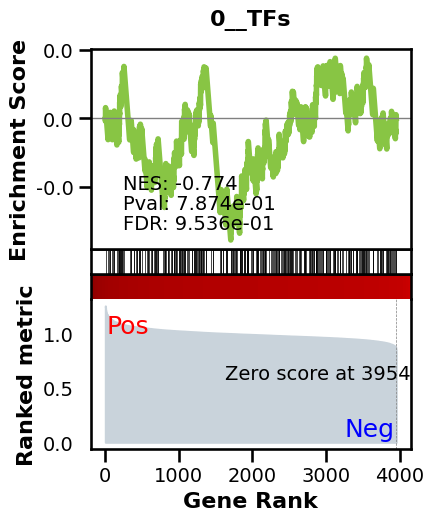

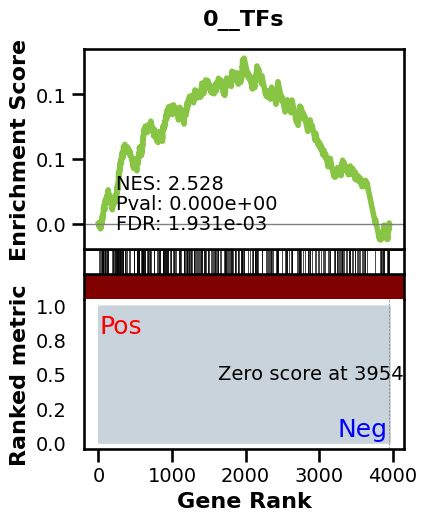

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2719 genes
intersection pct: 0.6874841972187105
precision:  0.0013238268130996498 
recall:  1.0 
random precision: 0.0013243138722656173



  0%|          | 0/128 [00:00<?, ?it/s]


  8%|▊         | 10/128 [00:00<00:01, 97.26it/s]


 16%|█▌        | 20/128 [00:00<00:01, 97.32it/s]


 23%|██▎       | 30/128 [00:00<00:01, 97.35it/s]


 31%|███▏      | 40/128 [00:00<00:00, 97.51it/s]


 39%|███▉      | 50/128 [00:00<00:00, 97.47it/s]


 47%|████▋     | 60/128 [00:00<00:00, 97.25it/s]


 55%|█████▍    | 70/128 [00:00<00:00, 97.01it/s]


 62%|██████▎   | 80/128 [00:00<00:00, 97.06it/s]


 70%|███████   | 90/128 [00:00<00:00, 97.22it/s]


 78%|███████▊  | 100/128 [00:01<00:00, 97.15it/s]


 86%|████████▌ | 110/128 [00:01<00:00, 97.41it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 97.42it/s]


100%|██████████| 128/128 [00:01<00:00, 97.13it/s]

Average Precision (AP):  0.0016622839894261062
Area Under Precision-Recall Curve (AUPRC):  0.001661603514128192
EPR: 3.4948276601816497


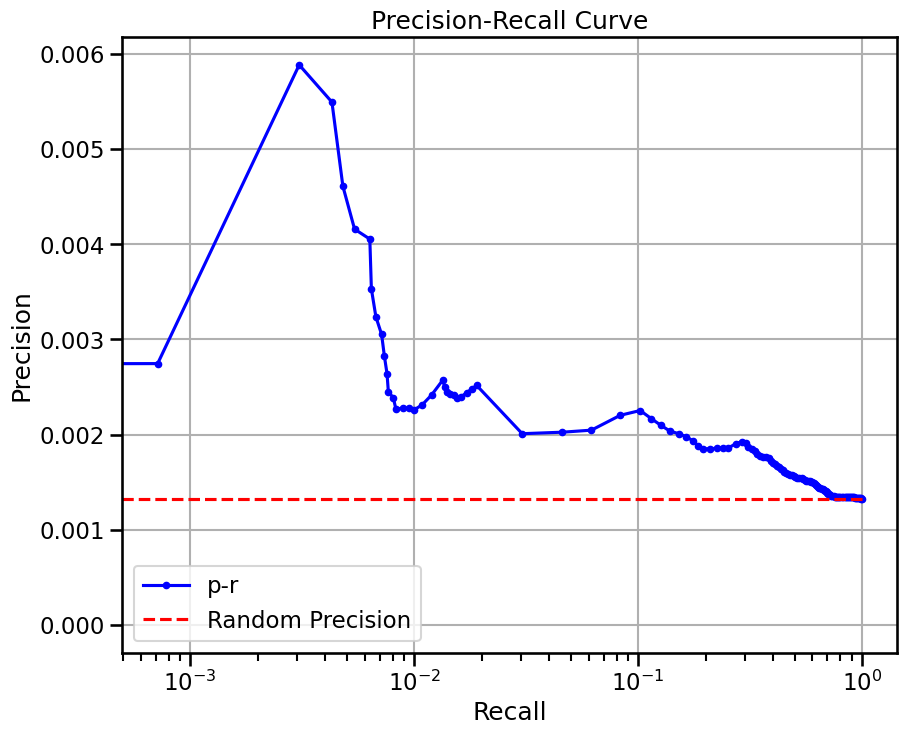

base enrichment


Top central genes: []


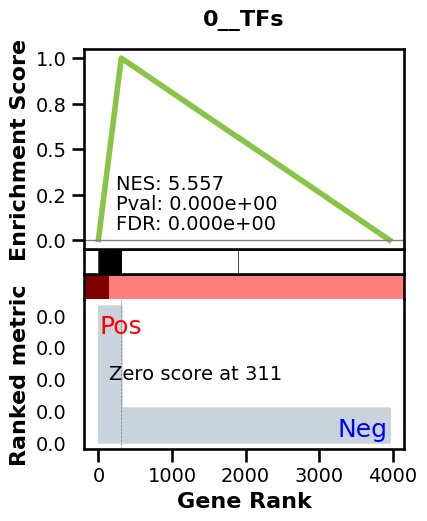

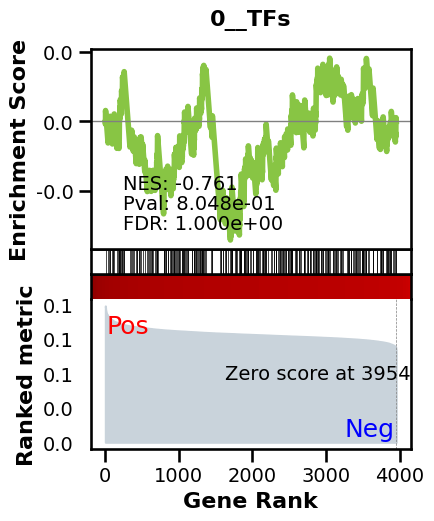

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2719 genes
intersection pct: 0.6874841972187105
precision:  0.00832973546327241 
recall:  0.6387044038009605 
random precision: 0.0013243138722656173



  0%|          | 0/128 [00:00<?, ?it/s]


  8%|▊         | 10/128 [00:00<00:01, 98.17it/s]


 16%|█▌        | 20/128 [00:00<00:01, 97.64it/s]


 23%|██▎       | 30/128 [00:00<00:01, 97.91it/s]


 31%|███▏      | 40/128 [00:00<00:00, 98.06it/s]


 39%|███▉      | 50/128 [00:00<00:00, 97.85it/s]


 47%|████▋     | 60/128 [00:00<00:00, 97.98it/s]


 55%|█████▍    | 70/128 [00:00<00:00, 98.08it/s]


 62%|██████▎   | 80/128 [00:00<00:00, 98.11it/s]


 70%|███████   | 90/128 [00:00<00:00, 98.00it/s]


 78%|███████▊  | 100/128 [00:01<00:00, 98.04it/s]


 86%|████████▌ | 110/128 [00:01<00:00, 97.87it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 97.79it/s]


100%|██████████| 128/128 [00:01<00:00, 97.88it/s]

Average Precision (AP):  0.007718237196161469
Area Under Precision-Recall Curve (AUPRC):  0.007200423655804186
EPR: 9.464806268456151


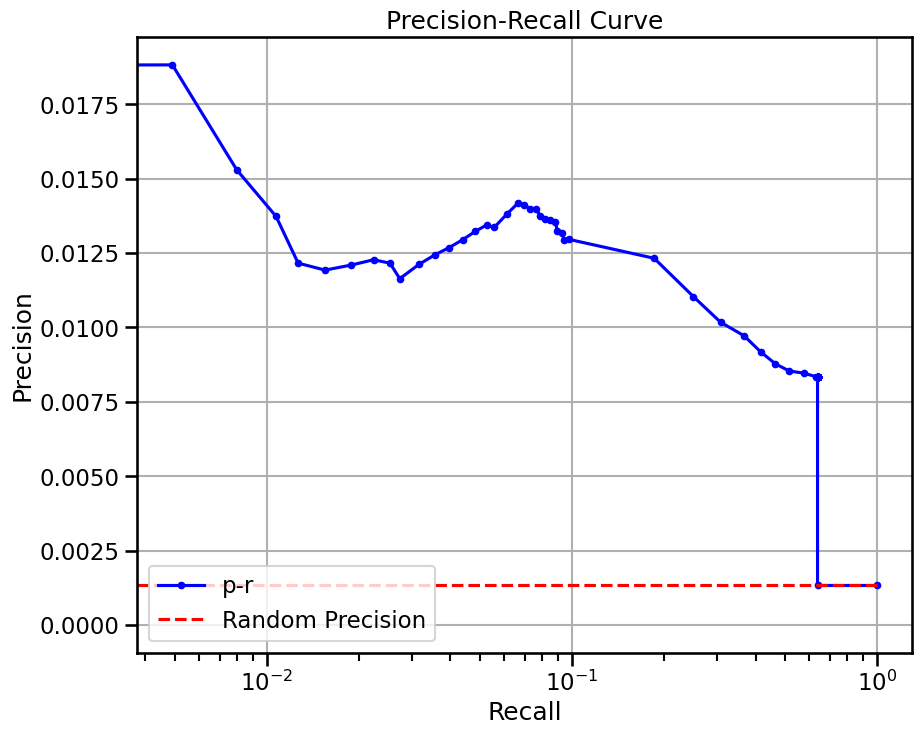

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:14,  2.74it/s]


  1%|          | 2/205 [00:00<01:14,  2.72it/s]


  1%|▏         | 3/205 [00:01<01:13,  2.75it/s]


  2%|▏         | 4/205 [00:01<01:12,  2.77it/s]


  2%|▏         | 5/205 [00:01<01:12,  2.78it/s]


  3%|▎         | 6/205 [00:02<01:11,  2.78it/s]


  3%|▎         | 7/205 [00:02<01:11,  2.78it/s]


  4%|▍         | 8/205 [00:02<01:10,  2.79it/s]


  4%|▍         | 9/205 [00:03<01:10,  2.79it/s]


  5%|▍         | 10/205 [00:03<01:09,  2.79it/s]


  5%|▌         | 11/205 [00:03<01:09,  2.79it/s]


  6%|▌         | 12/205 [00:04<01:09,  2.79it/s]


  6%|▋         | 13/205 [00:04<01:08,  2.79it/s]


  7%|▋         | 14/205 [00:05<01:08,  2.79it/s]


  7%|▋         | 15/205 [00:05<01:08,  2.79it/s]


  8%|▊         | 16/205 [00:05<01:07,  2.79it/s]


  8%|▊         | 17/205 [00:06<01:07,  2.79it/s]


  9%|▉         | 18/205 [00:06<01:07,  2.79it/s]


  9%|▉         | 19/205 [00:06<01:06,  2.79it/s]


 10%|▉         | 20/205 [00:07<01:06,  2.79it/s]


 10%|█         | 21/205 [00:07<01:06,  2.79it/s]


 11%|█         | 22/205 [00:07<01:05,  2.79it/s]


 11%|█         | 23/205 [00:08<01:05,  2.79it/s]


 12%|█▏        | 24/205 [00:08<01:04,  2.79it/s]


 12%|█▏        | 25/205 [00:08<01:04,  2.79it/s]


 13%|█▎        | 26/205 [00:09<01:04,  2.79it/s]


 13%|█▎        | 27/205 [00:09<01:03,  2.79it/s]


 14%|█▎        | 28/205 [00:10<01:03,  2.79it/s]


 14%|█▍        | 29/205 [00:10<01:03,  2.79it/s]


 15%|█▍        | 30/205 [00:10<01:02,  2.79it/s]


 15%|█▌        | 31/205 [00:11<01:02,  2.79it/s]


 16%|█▌        | 32/205 [00:11<01:02,  2.79it/s]


 16%|█▌        | 33/205 [00:11<01:01,  2.79it/s]


 17%|█▋        | 34/205 [00:12<01:01,  2.79it/s]


 17%|█▋        | 35/205 [00:12<01:00,  2.79it/s]


 18%|█▊        | 36/205 [00:12<01:00,  2.79it/s]


 18%|█▊        | 37/205 [00:13<01:00,  2.79it/s]


 19%|█▊        | 38/205 [00:13<00:59,  2.79it/s]


 19%|█▉        | 39/205 [00:14<00:59,  2.78it/s]


 20%|█▉        | 40/205 [00:14<00:59,  2.78it/s]


 20%|██        | 41/205 [00:14<00:58,  2.78it/s]


 20%|██        | 42/205 [00:15<00:58,  2.78it/s]


 21%|██        | 43/205 [00:15<00:58,  2.78it/s]


 21%|██▏       | 44/205 [00:15<00:58,  2.77it/s]


 22%|██▏       | 45/205 [00:16<00:57,  2.77it/s]


 22%|██▏       | 46/205 [00:16<00:57,  2.77it/s]


 23%|██▎       | 47/205 [00:16<00:56,  2.77it/s]


 23%|██▎       | 48/205 [00:17<00:56,  2.77it/s]


 24%|██▍       | 49/205 [00:17<00:56,  2.77it/s]


 24%|██▍       | 50/205 [00:17<00:55,  2.77it/s]


 25%|██▍       | 51/205 [00:18<00:55,  2.77it/s]


 25%|██▌       | 52/205 [00:18<00:55,  2.77it/s]


 26%|██▌       | 53/205 [00:19<00:54,  2.77it/s]


 26%|██▋       | 54/205 [00:19<00:54,  2.77it/s]


 27%|██▋       | 55/205 [00:19<00:54,  2.77it/s]


 27%|██▋       | 56/205 [00:20<00:53,  2.77it/s]


 28%|██▊       | 57/205 [00:20<00:53,  2.77it/s]


 28%|██▊       | 58/205 [00:20<00:52,  2.78it/s]


 29%|██▉       | 59/205 [00:21<00:52,  2.78it/s]


 29%|██▉       | 60/205 [00:21<00:52,  2.77it/s]


 30%|██▉       | 61/205 [00:21<00:51,  2.77it/s]


 30%|███       | 62/205 [00:22<00:51,  2.77it/s]


 31%|███       | 63/205 [00:22<00:51,  2.77it/s]


 31%|███       | 64/205 [00:23<00:50,  2.77it/s]


 32%|███▏      | 65/205 [00:23<00:50,  2.78it/s]


 32%|███▏      | 66/205 [00:23<00:50,  2.77it/s]


 33%|███▎      | 67/205 [00:24<00:49,  2.77it/s]


 33%|███▎      | 68/205 [00:24<00:49,  2.77it/s]


 34%|███▎      | 69/205 [00:24<00:49,  2.77it/s]


 34%|███▍      | 70/205 [00:25<00:48,  2.77it/s]


 35%|███▍      | 71/205 [00:25<00:48,  2.77it/s]


 35%|███▌      | 72/205 [00:25<00:47,  2.77it/s]


 36%|███▌      | 73/205 [00:26<00:47,  2.77it/s]


 36%|███▌      | 74/205 [00:26<00:47,  2.77it/s]


 37%|███▋      | 75/205 [00:26<00:46,  2.77it/s]


 37%|███▋      | 76/205 [00:27<00:46,  2.77it/s]


 38%|███▊      | 77/205 [00:27<00:46,  2.77it/s]


 38%|███▊      | 78/205 [00:28<00:45,  2.77it/s]


 39%|███▊      | 79/205 [00:28<00:45,  2.77it/s]


 39%|███▉      | 80/205 [00:28<00:45,  2.77it/s]


 40%|███▉      | 81/205 [00:29<00:44,  2.77it/s]


 40%|████      | 82/205 [00:29<00:44,  2.77it/s]


 40%|████      | 83/205 [00:29<00:43,  2.77it/s]


 41%|████      | 84/205 [00:30<00:43,  2.78it/s]


 41%|████▏     | 85/205 [00:30<00:43,  2.78it/s]


 42%|████▏     | 86/205 [00:30<00:42,  2.78it/s]


 42%|████▏     | 87/205 [00:31<00:42,  2.78it/s]


 43%|████▎     | 88/205 [00:31<00:42,  2.78it/s]


 43%|████▎     | 89/205 [00:32<00:41,  2.78it/s]


 44%|████▍     | 90/205 [00:32<00:41,  2.78it/s]


 44%|████▍     | 91/205 [00:32<00:41,  2.78it/s]


 45%|████▍     | 92/205 [00:33<00:40,  2.78it/s]


 45%|████▌     | 93/205 [00:33<00:40,  2.78it/s]


 46%|████▌     | 94/205 [00:33<00:39,  2.78it/s]


 46%|████▋     | 95/205 [00:34<00:39,  2.78it/s]


 47%|████▋     | 96/205 [00:34<00:39,  2.78it/s]


 47%|████▋     | 97/205 [00:34<00:38,  2.78it/s]


 48%|████▊     | 98/205 [00:35<00:38,  2.78it/s]


 48%|████▊     | 99/205 [00:35<00:38,  2.78it/s]


 49%|████▉     | 100/205 [00:35<00:37,  2.77it/s]


 49%|████▉     | 101/205 [00:36<00:37,  2.77it/s]


 50%|████▉     | 102/205 [00:36<00:37,  2.77it/s]


 50%|█████     | 103/205 [00:37<00:36,  2.77it/s]


 51%|█████     | 104/205 [00:37<00:36,  2.77it/s]


 51%|█████     | 105/205 [00:37<00:36,  2.77it/s]


 52%|█████▏    | 106/205 [00:38<00:35,  2.77it/s]


 52%|█████▏    | 107/205 [00:38<00:35,  2.77it/s]


 53%|█████▎    | 108/205 [00:38<00:34,  2.78it/s]


 53%|█████▎    | 109/205 [00:39<00:34,  2.77it/s]


 54%|█████▎    | 110/205 [00:39<00:34,  2.77it/s]


 54%|█████▍    | 111/205 [00:39<00:33,  2.77it/s]


 55%|█████▍    | 112/205 [00:40<00:33,  2.78it/s]


 55%|█████▌    | 113/205 [00:40<00:33,  2.78it/s]


 56%|█████▌    | 114/205 [00:41<00:32,  2.77it/s]


 56%|█████▌    | 115/205 [00:41<00:32,  2.77it/s]


 57%|█████▋    | 116/205 [00:41<00:32,  2.78it/s]


 57%|█████▋    | 117/205 [00:42<00:31,  2.77it/s]


 58%|█████▊    | 118/205 [00:42<00:31,  2.77it/s]


 58%|█████▊    | 119/205 [00:42<00:30,  2.78it/s]


 59%|█████▊    | 120/205 [00:43<00:30,  2.77it/s]


 59%|█████▉    | 121/205 [00:43<00:30,  2.77it/s]


 60%|█████▉    | 122/205 [00:43<00:29,  2.77it/s]


 60%|██████    | 123/205 [00:44<00:29,  2.77it/s]


 60%|██████    | 124/205 [00:44<00:29,  2.77it/s]


 61%|██████    | 125/205 [00:45<00:29,  2.72it/s]


 61%|██████▏   | 126/205 [00:45<00:28,  2.74it/s]


 62%|██████▏   | 127/205 [00:45<00:28,  2.75it/s]


 62%|██████▏   | 128/205 [00:46<00:27,  2.76it/s]


 63%|██████▎   | 129/205 [00:46<00:27,  2.76it/s]


 63%|██████▎   | 130/205 [00:46<00:27,  2.76it/s]


 64%|██████▍   | 131/205 [00:47<00:26,  2.77it/s]


 64%|██████▍   | 132/205 [00:47<00:26,  2.77it/s]


 65%|██████▍   | 133/205 [00:47<00:25,  2.77it/s]


 65%|██████▌   | 134/205 [00:48<00:25,  2.77it/s]


 66%|██████▌   | 135/205 [00:48<00:25,  2.77it/s]


 66%|██████▋   | 136/205 [00:48<00:24,  2.77it/s]


 67%|██████▋   | 137/205 [00:49<00:24,  2.77it/s]


 67%|██████▋   | 138/205 [00:49<00:24,  2.77it/s]


 68%|██████▊   | 139/205 [00:50<00:23,  2.77it/s]


 68%|██████▊   | 140/205 [00:50<00:23,  2.77it/s]


 69%|██████▉   | 141/205 [00:50<00:23,  2.77it/s]


 69%|██████▉   | 142/205 [00:51<00:22,  2.77it/s]


 70%|██████▉   | 143/205 [00:51<00:22,  2.77it/s]


 70%|███████   | 144/205 [00:51<00:22,  2.77it/s]


 71%|███████   | 145/205 [00:52<00:21,  2.77it/s]


 71%|███████   | 146/205 [00:52<00:21,  2.77it/s]


 72%|███████▏  | 147/205 [00:52<00:20,  2.77it/s]


 72%|███████▏  | 148/205 [00:53<00:20,  2.77it/s]


 73%|███████▎  | 149/205 [00:53<00:20,  2.77it/s]


 73%|███████▎  | 150/205 [00:54<00:19,  2.77it/s]


 74%|███████▎  | 151/205 [00:54<00:19,  2.77it/s]


 74%|███████▍  | 152/205 [00:54<00:19,  2.77it/s]


 75%|███████▍  | 153/205 [00:55<00:18,  2.74it/s]


 75%|███████▌  | 154/205 [00:55<00:18,  2.75it/s]


 76%|███████▌  | 155/205 [00:55<00:18,  2.76it/s]


 76%|███████▌  | 156/205 [00:56<00:17,  2.77it/s]


 77%|███████▋  | 157/205 [00:56<00:17,  2.77it/s]


 77%|███████▋  | 158/205 [00:56<00:16,  2.77it/s]


 78%|███████▊  | 159/205 [00:57<00:16,  2.77it/s]


 78%|███████▊  | 160/205 [00:57<00:16,  2.77it/s]


 79%|███████▊  | 161/205 [00:58<00:15,  2.77it/s]


 79%|███████▉  | 162/205 [00:58<00:15,  2.77it/s]


 80%|███████▉  | 163/205 [00:58<00:15,  2.76it/s]


 80%|████████  | 164/205 [00:59<00:15,  2.71it/s]


 80%|████████  | 165/205 [00:59<00:14,  2.72it/s]


 81%|████████  | 166/205 [00:59<00:14,  2.73it/s]


 81%|████████▏ | 167/205 [01:00<00:13,  2.74it/s]


 82%|████████▏ | 168/205 [01:00<00:13,  2.75it/s]


 82%|████████▏ | 169/205 [01:00<00:13,  2.75it/s]


 83%|████████▎ | 170/205 [01:01<00:12,  2.75it/s]


 83%|████████▎ | 171/205 [01:01<00:12,  2.75it/s]


 84%|████████▍ | 172/205 [01:02<00:11,  2.75it/s]


 84%|████████▍ | 173/205 [01:02<00:11,  2.76it/s]


 85%|████████▍ | 174/205 [01:02<00:11,  2.76it/s]


 85%|████████▌ | 175/205 [01:03<00:10,  2.75it/s]


 86%|████████▌ | 176/205 [01:03<00:10,  2.75it/s]


 86%|████████▋ | 177/205 [01:03<00:10,  2.76it/s]


 87%|████████▋ | 178/205 [01:04<00:09,  2.76it/s]


 87%|████████▋ | 179/205 [01:04<00:09,  2.76it/s]


 88%|████████▊ | 180/205 [01:04<00:09,  2.76it/s]


 88%|████████▊ | 181/205 [01:05<00:08,  2.76it/s]


 89%|████████▉ | 182/205 [01:05<00:08,  2.76it/s]


 89%|████████▉ | 183/205 [01:06<00:07,  2.76it/s]


 90%|████████▉ | 184/205 [01:06<00:07,  2.76it/s]


 90%|█████████ | 185/205 [01:06<00:07,  2.76it/s]


 91%|█████████ | 186/205 [01:07<00:06,  2.76it/s]


 91%|█████████ | 187/205 [01:07<00:06,  2.77it/s]


 92%|█████████▏| 188/205 [01:07<00:06,  2.77it/s]


 92%|█████████▏| 189/205 [01:08<00:05,  2.76it/s]


 93%|█████████▎| 190/205 [01:08<00:05,  2.75it/s]


 93%|█████████▎| 191/205 [01:08<00:05,  2.75it/s]


 94%|█████████▎| 192/205 [01:09<00:04,  2.76it/s]


 94%|█████████▍| 193/205 [01:09<00:04,  2.76it/s]


 95%|█████████▍| 194/205 [01:10<00:03,  2.76it/s]


 95%|█████████▌| 195/205 [01:10<00:03,  2.76it/s]


 96%|█████████▌| 196/205 [01:10<00:03,  2.76it/s]


 96%|█████████▌| 197/205 [01:11<00:02,  2.76it/s]


 97%|█████████▋| 198/205 [01:11<00:02,  2.76it/s]


 97%|█████████▋| 199/205 [01:11<00:02,  2.76it/s]


 98%|█████████▊| 200/205 [01:12<00:01,  2.76it/s]


 98%|█████████▊| 201/205 [01:12<00:01,  2.76it/s]


 99%|█████████▊| 202/205 [01:12<00:01,  2.76it/s]


 99%|█████████▉| 203/205 [01:13<00:00,  2.76it/s]


100%|█████████▉| 204/205 [01:13<00:00,  2.76it/s]


100%|██████████| 205/205 [01:13<00:00,  2.95it/s]


100%|██████████| 205/205 [01:13<00:00,  2.77it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


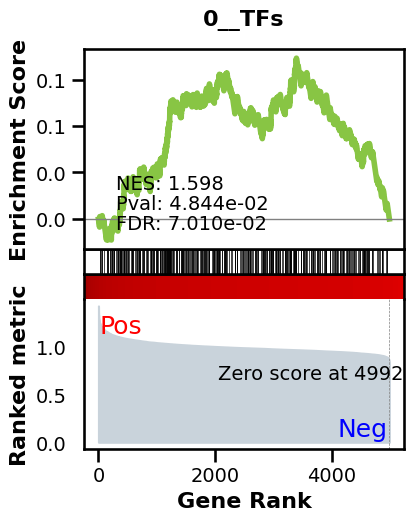

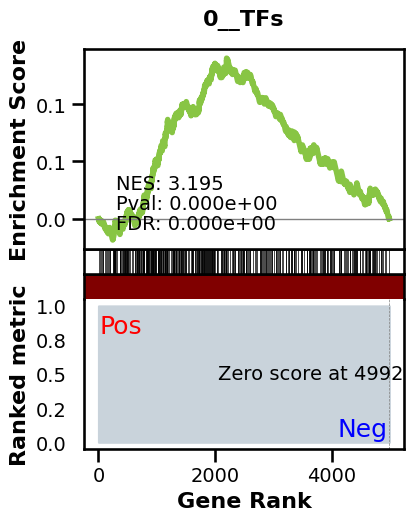

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.7300220308431804
precision:  0.0017105944027653117 
recall:  1.0 
random precision: 0.0017110638304279806



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 49.46it/s]


  8%|▊         | 10/128 [00:00<00:02, 49.73it/s]


 12%|█▎        | 16/128 [00:00<00:02, 49.88it/s]


 16%|█▋        | 21/128 [00:00<00:02, 49.86it/s]


 21%|██        | 27/128 [00:00<00:02, 50.00it/s]


 25%|██▌       | 32/128 [00:00<00:01, 49.98it/s]


 29%|██▉       | 37/128 [00:00<00:01, 49.91it/s]


 33%|███▎      | 42/128 [00:00<00:01, 49.84it/s]


 37%|███▋      | 47/128 [00:00<00:01, 49.83it/s]


 41%|████      | 52/128 [00:01<00:01, 49.88it/s]


 45%|████▍     | 57/128 [00:01<00:01, 49.91it/s]


 48%|████▊     | 62/128 [00:01<00:01, 49.84it/s]


 53%|█████▎    | 68/128 [00:01<00:01, 49.92it/s]


 58%|█████▊    | 74/128 [00:01<00:01, 50.00it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 50.06it/s]


 67%|██████▋   | 86/128 [00:01<00:00, 50.05it/s]


 72%|███████▏  | 92/128 [00:01<00:00, 50.05it/s]


 77%|███████▋  | 98/128 [00:01<00:00, 49.95it/s]


 80%|████████  | 103/128 [00:02<00:00, 49.96it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 49.96it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 49.99it/s]


 93%|█████████▎| 119/128 [00:02<00:00, 49.99it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 50.02it/s]


100%|██████████| 128/128 [00:02<00:00, 49.94it/s]

Average Precision (AP):  0.0019005381928769785
Area Under Precision-Recall Curve (AUPRC):  0.0018992462327984145


EPR: 0.513450135628172


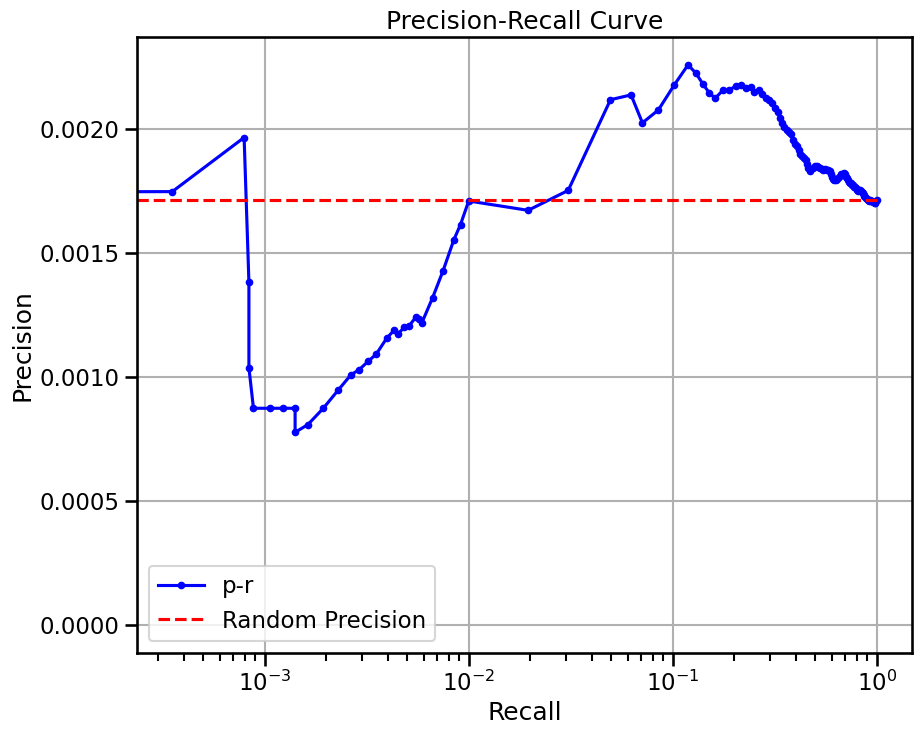

base enrichment


Top central genes: []


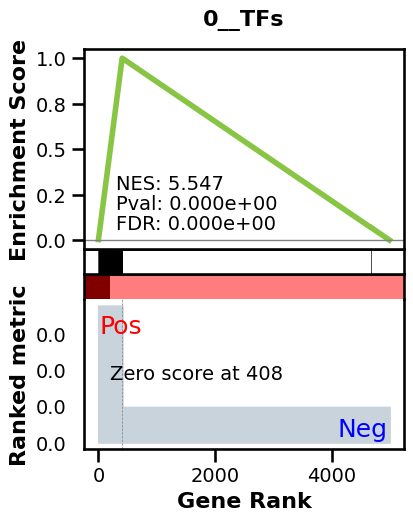

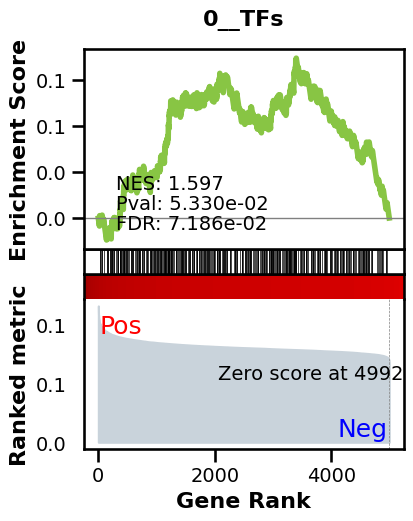

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3645 genes
intersection pct: 0.7300220308431804
precision:  0.007137593669580201 
recall:  0.4155409864918379 
random precision: 0.0017110638304279806



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.57it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.48it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.36it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.38it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.32it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.33it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.36it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.37it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.36it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.27it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.30it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.28it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.31it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.36it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.36it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 51.41it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.45it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.35it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 51.38it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 51.44it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.42it/s]


100%|██████████| 128/128 [00:02<00:00, 51.35it/s]

Average Precision (AP):  0.005250485465606558
Area Under Precision-Recall Curve (AUPRC):  0.004754334048828247
EPR: 5.908800888990014


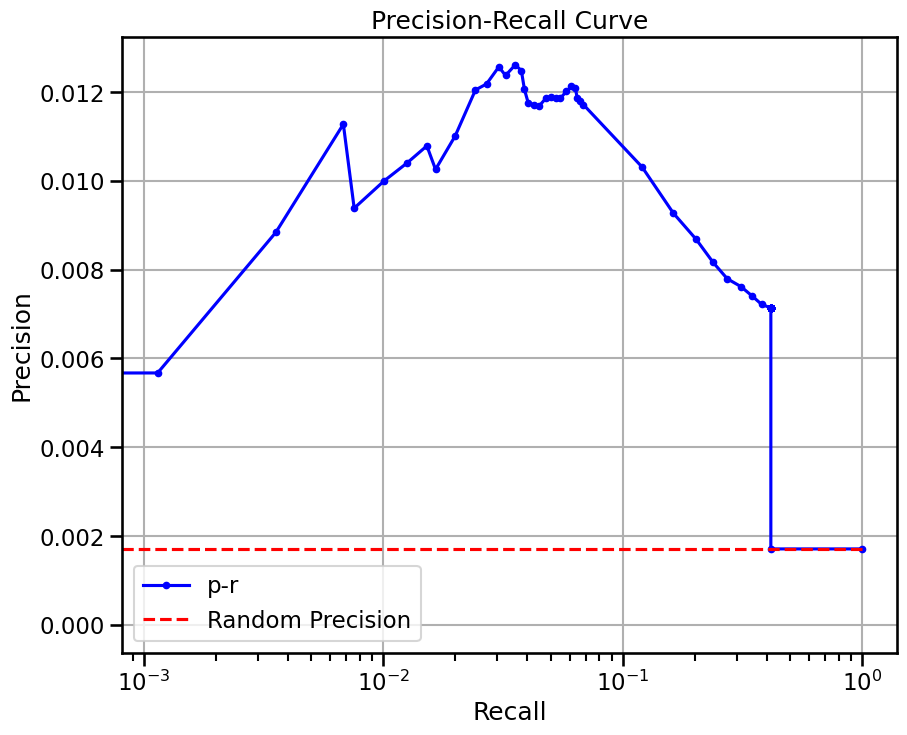

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/205 [00:00<?, ?it/s]


  0%|          | 1/205 [00:00<01:18,  2.61it/s]


  1%|          | 2/205 [00:00<01:09,  2.92it/s]


  1%|▏         | 3/205 [00:01<01:06,  3.04it/s]


  2%|▏         | 4/205 [00:01<01:04,  3.10it/s]


  2%|▏         | 5/205 [00:01<01:03,  3.14it/s]


  3%|▎         | 6/205 [00:01<01:02,  3.16it/s]


  3%|▎         | 7/205 [00:02<01:02,  3.18it/s]


  4%|▍         | 8/205 [00:02<01:01,  3.19it/s]


  4%|▍         | 9/205 [00:02<01:01,  3.19it/s]


  5%|▍         | 10/205 [00:03<01:01,  3.20it/s]


  5%|▌         | 11/205 [00:03<01:01,  3.16it/s]


  6%|▌         | 12/205 [00:03<01:00,  3.17it/s]


  6%|▋         | 13/205 [00:04<01:00,  3.18it/s]


  7%|▋         | 14/205 [00:04<00:59,  3.19it/s]


  7%|▋         | 15/205 [00:04<00:59,  3.19it/s]


  8%|▊         | 16/205 [00:05<00:59,  3.20it/s]


  8%|▊         | 17/205 [00:05<00:58,  3.20it/s]


  9%|▉         | 18/205 [00:05<00:58,  3.20it/s]


  9%|▉         | 19/205 [00:06<00:58,  3.17it/s]


 10%|▉         | 20/205 [00:06<00:58,  3.18it/s]


 10%|█         | 21/205 [00:06<00:57,  3.19it/s]


 11%|█         | 22/205 [00:06<00:57,  3.19it/s]


 11%|█         | 23/205 [00:07<00:56,  3.19it/s]


 12%|█▏        | 24/205 [00:07<00:56,  3.19it/s]


 12%|█▏        | 25/205 [00:07<00:56,  3.20it/s]


 13%|█▎        | 26/205 [00:08<00:55,  3.20it/s]


 13%|█▎        | 27/205 [00:08<00:55,  3.20it/s]


 14%|█▎        | 28/205 [00:08<00:55,  3.20it/s]


 14%|█▍        | 29/205 [00:09<00:55,  3.17it/s]


 15%|█▍        | 30/205 [00:09<00:55,  3.18it/s]


 15%|█▌        | 31/205 [00:09<00:54,  3.18it/s]


 16%|█▌        | 32/205 [00:10<00:54,  3.18it/s]


 16%|█▌        | 33/205 [00:10<00:54,  3.18it/s]


 17%|█▋        | 34/205 [00:10<00:53,  3.19it/s]


 17%|█▋        | 35/205 [00:11<00:53,  3.19it/s]


 18%|█▊        | 36/205 [00:11<00:52,  3.19it/s]


 18%|█▊        | 37/205 [00:11<00:52,  3.20it/s]


 19%|█▊        | 38/205 [00:11<00:52,  3.20it/s]


 19%|█▉        | 39/205 [00:12<00:51,  3.20it/s]


 20%|█▉        | 40/205 [00:12<00:51,  3.20it/s]


 20%|██        | 41/205 [00:12<00:51,  3.20it/s]


 20%|██        | 42/205 [00:13<00:50,  3.20it/s]


 21%|██        | 43/205 [00:13<00:50,  3.20it/s]


 21%|██▏       | 44/205 [00:13<00:50,  3.19it/s]


 22%|██▏       | 45/205 [00:14<00:50,  3.19it/s]


 22%|██▏       | 46/205 [00:14<00:49,  3.19it/s]


 23%|██▎       | 47/205 [00:14<00:49,  3.20it/s]


 23%|██▎       | 48/205 [00:15<00:49,  3.20it/s]


 24%|██▍       | 49/205 [00:15<00:48,  3.20it/s]


 24%|██▍       | 50/205 [00:15<00:48,  3.20it/s]


 25%|██▍       | 51/205 [00:16<00:48,  3.20it/s]


 25%|██▌       | 52/205 [00:16<00:47,  3.19it/s]


 26%|██▌       | 53/205 [00:16<00:47,  3.19it/s]


 26%|██▋       | 54/205 [00:16<00:47,  3.20it/s]


 27%|██▋       | 55/205 [00:17<00:46,  3.20it/s]


 27%|██▋       | 56/205 [00:17<00:46,  3.19it/s]


 28%|██▊       | 57/205 [00:17<00:46,  3.19it/s]


 28%|██▊       | 58/205 [00:18<00:46,  3.18it/s]


 29%|██▉       | 59/205 [00:18<00:45,  3.18it/s]


 29%|██▉       | 60/205 [00:18<00:45,  3.18it/s]


 30%|██▉       | 61/205 [00:19<00:45,  3.18it/s]


 30%|███       | 62/205 [00:19<00:44,  3.18it/s]


 31%|███       | 63/205 [00:19<00:44,  3.18it/s]


 31%|███       | 64/205 [00:20<00:44,  3.18it/s]


 32%|███▏      | 65/205 [00:20<00:44,  3.18it/s]


 32%|███▏      | 66/205 [00:20<00:43,  3.17it/s]


 33%|███▎      | 67/205 [00:21<00:43,  3.17it/s]


 33%|███▎      | 68/205 [00:21<00:43,  3.16it/s]


 34%|███▎      | 69/205 [00:21<00:42,  3.17it/s]


 34%|███▍      | 70/205 [00:22<00:42,  3.17it/s]


 35%|███▍      | 71/205 [00:22<00:42,  3.17it/s]


 35%|███▌      | 72/205 [00:22<00:41,  3.17it/s]


 36%|███▌      | 73/205 [00:22<00:41,  3.17it/s]


 36%|███▌      | 74/205 [00:23<00:41,  3.18it/s]


 37%|███▋      | 75/205 [00:23<00:40,  3.18it/s]


 37%|███▋      | 76/205 [00:23<00:40,  3.17it/s]


 38%|███▊      | 77/205 [00:24<00:40,  3.17it/s]


 38%|███▊      | 78/205 [00:24<00:40,  3.17it/s]


 39%|███▊      | 79/205 [00:24<00:39,  3.17it/s]


 39%|███▉      | 80/205 [00:25<00:39,  3.17it/s]


 40%|███▉      | 81/205 [00:25<00:39,  3.17it/s]


 40%|████      | 82/205 [00:25<00:38,  3.17it/s]


 40%|████      | 83/205 [00:26<00:38,  3.17it/s]


 41%|████      | 84/205 [00:26<00:38,  3.17it/s]


 41%|████▏     | 85/205 [00:26<00:37,  3.17it/s]


 42%|████▏     | 86/205 [00:27<00:37,  3.17it/s]


 42%|████▏     | 87/205 [00:27<00:37,  3.17it/s]


 43%|████▎     | 88/205 [00:27<00:36,  3.17it/s]


 43%|████▎     | 89/205 [00:28<00:36,  3.17it/s]


 44%|████▍     | 90/205 [00:28<00:36,  3.18it/s]


 44%|████▍     | 91/205 [00:28<00:35,  3.18it/s]


 45%|████▍     | 92/205 [00:28<00:35,  3.18it/s]


 45%|████▌     | 93/205 [00:29<00:35,  3.17it/s]


 46%|████▌     | 94/205 [00:29<00:34,  3.17it/s]


 46%|████▋     | 95/205 [00:29<00:34,  3.17it/s]


 47%|████▋     | 96/205 [00:30<00:34,  3.17it/s]


 47%|████▋     | 97/205 [00:30<00:34,  3.17it/s]


 48%|████▊     | 98/205 [00:30<00:33,  3.17it/s]


 48%|████▊     | 99/205 [00:31<00:33,  3.17it/s]


 49%|████▉     | 100/205 [00:31<00:33,  3.17it/s]


 49%|████▉     | 101/205 [00:31<00:32,  3.17it/s]


 50%|████▉     | 102/205 [00:32<00:32,  3.17it/s]


 50%|█████     | 103/205 [00:32<00:32,  3.17it/s]


 51%|█████     | 104/205 [00:32<00:31,  3.16it/s]


 51%|█████     | 105/205 [00:33<00:31,  3.16it/s]


 52%|█████▏    | 106/205 [00:33<00:31,  3.17it/s]


 52%|█████▏    | 107/205 [00:33<00:30,  3.17it/s]


 53%|█████▎    | 108/205 [00:34<00:30,  3.17it/s]


 53%|█████▎    | 109/205 [00:34<00:30,  3.17it/s]


 54%|█████▎    | 110/205 [00:34<00:30,  3.16it/s]


 54%|█████▍    | 111/205 [00:34<00:29,  3.17it/s]


 55%|█████▍    | 112/205 [00:35<00:29,  3.17it/s]


 55%|█████▌    | 113/205 [00:35<00:29,  3.17it/s]


 56%|█████▌    | 114/205 [00:35<00:28,  3.17it/s]


 56%|█████▌    | 115/205 [00:36<00:28,  3.17it/s]


 57%|█████▋    | 116/205 [00:36<00:28,  3.17it/s]


 57%|█████▋    | 117/205 [00:36<00:27,  3.17it/s]


 58%|█████▊    | 118/205 [00:37<00:27,  3.17it/s]


 58%|█████▊    | 119/205 [00:37<00:27,  3.17it/s]


 59%|█████▊    | 120/205 [00:37<00:26,  3.17it/s]


 59%|█████▉    | 121/205 [00:38<00:26,  3.17it/s]


 60%|█████▉    | 122/205 [00:38<00:26,  3.17it/s]


 60%|██████    | 123/205 [00:38<00:25,  3.17it/s]


 60%|██████    | 124/205 [00:39<00:25,  3.17it/s]


 61%|██████    | 125/205 [00:39<00:25,  3.17it/s]


 61%|██████▏   | 126/205 [00:39<00:24,  3.17it/s]


 62%|██████▏   | 127/205 [00:40<00:24,  3.17it/s]


 62%|██████▏   | 128/205 [00:40<00:24,  3.17it/s]


 63%|██████▎   | 129/205 [00:40<00:23,  3.17it/s]


 63%|██████▎   | 130/205 [00:40<00:23,  3.17it/s]


 64%|██████▍   | 131/205 [00:41<00:23,  3.17it/s]


 64%|██████▍   | 132/205 [00:41<00:23,  3.17it/s]


 65%|██████▍   | 133/205 [00:41<00:22,  3.17it/s]


 65%|██████▌   | 134/205 [00:42<00:22,  3.17it/s]


 66%|██████▌   | 135/205 [00:42<00:22,  3.17it/s]


 66%|██████▋   | 136/205 [00:42<00:21,  3.17it/s]


 67%|██████▋   | 137/205 [00:43<00:21,  3.17it/s]


 67%|██████▋   | 138/205 [00:43<00:21,  3.17it/s]


 68%|██████▊   | 139/205 [00:43<00:20,  3.17it/s]


 68%|██████▊   | 140/205 [00:44<00:20,  3.16it/s]


 69%|██████▉   | 141/205 [00:44<00:20,  3.17it/s]


 69%|██████▉   | 142/205 [00:44<00:19,  3.16it/s]


 70%|██████▉   | 143/205 [00:45<00:19,  3.16it/s]


 70%|███████   | 144/205 [00:45<00:19,  3.16it/s]


 71%|███████   | 145/205 [00:45<00:18,  3.16it/s]


 71%|███████   | 146/205 [00:46<00:18,  3.16it/s]


 72%|███████▏  | 147/205 [00:46<00:18,  3.17it/s]


 72%|███████▏  | 148/205 [00:46<00:18,  3.17it/s]


 73%|███████▎  | 149/205 [00:46<00:17,  3.17it/s]


 73%|███████▎  | 150/205 [00:47<00:17,  3.17it/s]


 74%|███████▎  | 151/205 [00:47<00:17,  3.17it/s]


 74%|███████▍  | 152/205 [00:47<00:16,  3.17it/s]


 75%|███████▍  | 153/205 [00:48<00:16,  3.18it/s]


 75%|███████▌  | 154/205 [00:48<00:16,  3.18it/s]


 76%|███████▌  | 155/205 [00:48<00:15,  3.18it/s]


 76%|███████▌  | 156/205 [00:49<00:15,  3.18it/s]


 77%|███████▋  | 157/205 [00:49<00:15,  3.18it/s]


 77%|███████▋  | 158/205 [00:49<00:14,  3.18it/s]


 78%|███████▊  | 159/205 [00:50<00:14,  3.18it/s]


 78%|███████▊  | 160/205 [00:50<00:14,  3.18it/s]


 79%|███████▊  | 161/205 [00:50<00:13,  3.18it/s]


 79%|███████▉  | 162/205 [00:51<00:13,  3.18it/s]


 80%|███████▉  | 163/205 [00:51<00:13,  3.18it/s]


 80%|████████  | 164/205 [00:51<00:12,  3.18it/s]


 80%|████████  | 165/205 [00:51<00:12,  3.18it/s]


 81%|████████  | 166/205 [00:52<00:12,  3.18it/s]


 81%|████████▏ | 167/205 [00:52<00:11,  3.18it/s]


 82%|████████▏ | 168/205 [00:52<00:11,  3.18it/s]


 82%|████████▏ | 169/205 [00:53<00:11,  3.18it/s]


 83%|████████▎ | 170/205 [00:53<00:11,  3.18it/s]


 83%|████████▎ | 171/205 [00:53<00:10,  3.18it/s]


 84%|████████▍ | 172/205 [00:54<00:10,  3.18it/s]


 84%|████████▍ | 173/205 [00:54<00:10,  3.18it/s]


 85%|████████▍ | 174/205 [00:54<00:09,  3.18it/s]


 85%|████████▌ | 175/205 [00:55<00:09,  3.17it/s]


 86%|████████▌ | 176/205 [00:55<00:09,  3.18it/s]


 86%|████████▋ | 177/205 [00:55<00:08,  3.18it/s]


 87%|████████▋ | 178/205 [00:56<00:08,  3.18it/s]


 87%|████████▋ | 179/205 [00:56<00:08,  3.18it/s]


 88%|████████▊ | 180/205 [00:56<00:07,  3.18it/s]


 88%|████████▊ | 181/205 [00:57<00:07,  3.18it/s]


 89%|████████▉ | 182/205 [00:57<00:07,  3.18it/s]


 89%|████████▉ | 183/205 [00:57<00:06,  3.18it/s]


 90%|████████▉ | 184/205 [00:57<00:06,  3.18it/s]


 90%|█████████ | 185/205 [00:58<00:06,  3.18it/s]


 91%|█████████ | 186/205 [00:58<00:05,  3.17it/s]


 91%|█████████ | 187/205 [00:58<00:05,  3.18it/s]


 92%|█████████▏| 188/205 [00:59<00:05,  3.18it/s]


 92%|█████████▏| 189/205 [00:59<00:05,  3.17it/s]


 93%|█████████▎| 190/205 [00:59<00:04,  3.17it/s]


 93%|█████████▎| 191/205 [01:00<00:04,  3.17it/s]


 94%|█████████▎| 192/205 [01:00<00:04,  3.17it/s]


 94%|█████████▍| 193/205 [01:00<00:03,  3.17it/s]


 95%|█████████▍| 194/205 [01:01<00:03,  3.17it/s]


 95%|█████████▌| 195/205 [01:01<00:03,  3.17it/s]


 96%|█████████▌| 196/205 [01:01<00:02,  3.17it/s]


 96%|█████████▌| 197/205 [01:02<00:02,  3.17it/s]


 97%|█████████▋| 198/205 [01:02<00:02,  3.17it/s]


 97%|█████████▋| 199/205 [01:02<00:01,  3.17it/s]


 98%|█████████▊| 200/205 [01:03<00:01,  3.17it/s]


 98%|█████████▊| 201/205 [01:03<00:01,  3.17it/s]


 99%|█████████▊| 202/205 [01:03<00:00,  3.17it/s]


 99%|█████████▉| 203/205 [01:03<00:00,  3.18it/s]


100%|█████████▉| 204/205 [01:04<00:00,  3.17it/s]


100%|██████████| 205/205 [01:04<00:00,  3.22it/s]


100%|██████████| 205/205 [01:04<00:00,  3.18it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


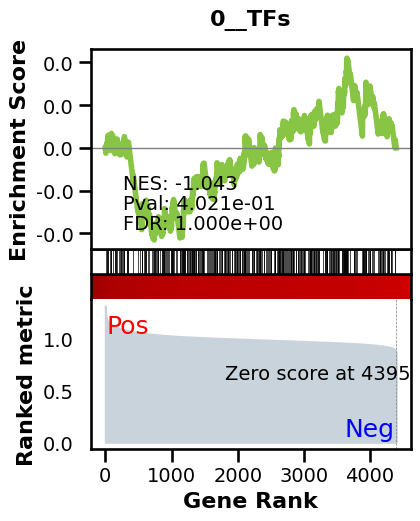

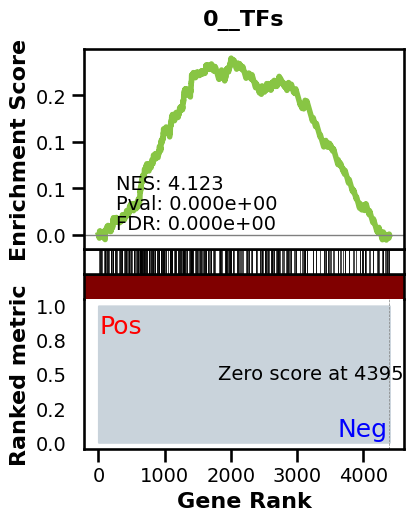

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2994 genes
intersection pct: 0.681073703366697
precision:  0.0006213718909651858 
recall:  1.0 
random precision: 0.0006215794993484016



  0%|          | 0/128 [00:00<?, ?it/s]


  7%|▋         | 9/128 [00:00<00:01, 83.16it/s]


 14%|█▍        | 18/128 [00:00<00:01, 82.68it/s]


 21%|██        | 27/128 [00:00<00:01, 82.68it/s]


 28%|██▊       | 36/128 [00:00<00:01, 82.66it/s]


 35%|███▌      | 45/128 [00:00<00:01, 82.71it/s]


 42%|████▏     | 54/128 [00:00<00:00, 82.63it/s]


 49%|████▉     | 63/128 [00:00<00:00, 82.64it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 82.65it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 82.78it/s]


 70%|███████   | 90/128 [00:01<00:00, 82.76it/s]


 77%|███████▋  | 99/128 [00:01<00:00, 82.68it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 82.85it/s]


 91%|█████████▏| 117/128 [00:01<00:00, 82.70it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 82.63it/s]


100%|██████████| 128/128 [00:01<00:00, 82.66it/s]

Average Precision (AP):  0.0007582972979364959
Area Under Precision-Recall Curve (AUPRC):  0.0007584681086411486
EPR: 1.73458496930819


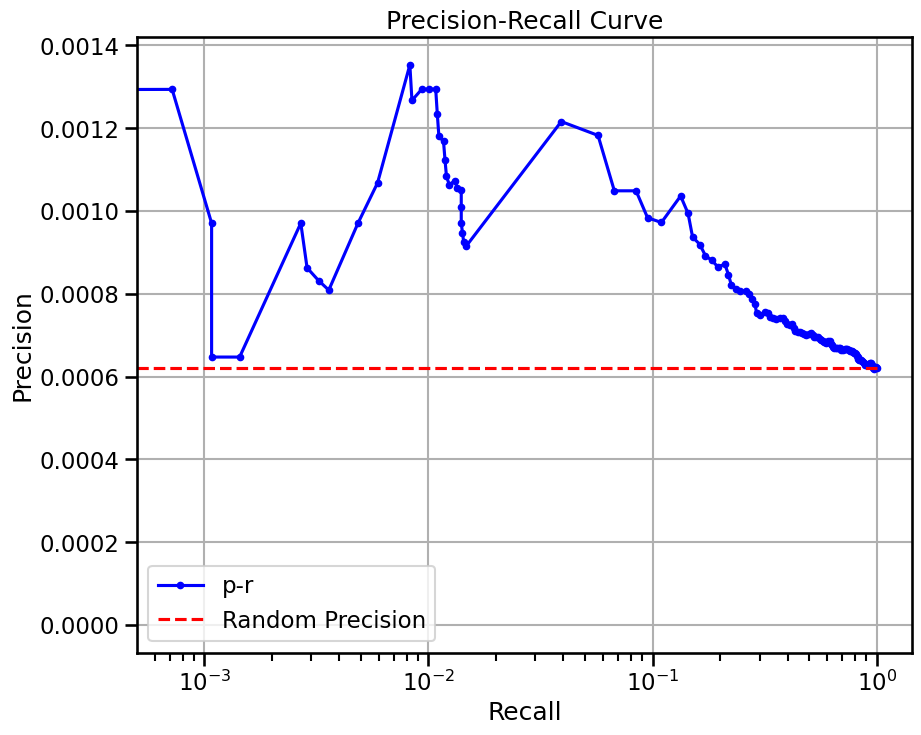

base enrichment


Top central genes: []


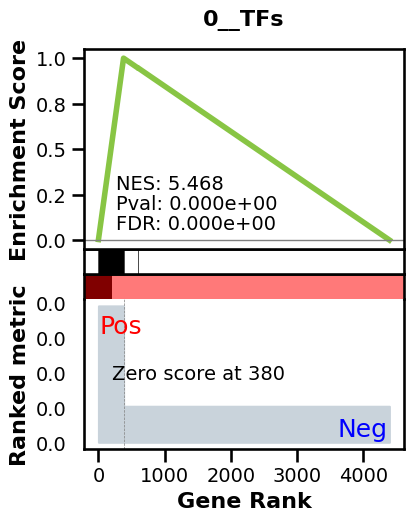

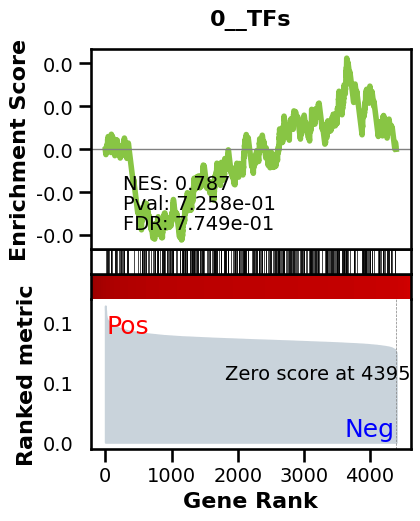

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2994 genes
intersection pct: 0.681073703366697
precision:  0.0016211284357332551 
recall:  0.28581687612208256 
random precision: 0.0006215794993484016



  0%|          | 0/128 [00:00<?, ?it/s]


  7%|▋         | 9/128 [00:00<00:01, 81.55it/s]


 14%|█▍        | 18/128 [00:00<00:01, 81.41it/s]


 21%|██        | 27/128 [00:00<00:01, 81.10it/s]


 28%|██▊       | 36/128 [00:00<00:01, 80.81it/s]


 35%|███▌      | 45/128 [00:00<00:01, 80.76it/s]


 42%|████▏     | 54/128 [00:00<00:00, 80.94it/s]


 49%|████▉     | 63/128 [00:00<00:00, 80.77it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 81.26it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 81.61it/s]


 70%|███████   | 90/128 [00:01<00:00, 81.70it/s]


 77%|███████▋  | 99/128 [00:01<00:00, 81.35it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 81.41it/s]


 91%|█████████▏| 117/128 [00:01<00:00, 81.20it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 80.97it/s]


100%|██████████| 128/128 [00:01<00:00, 81.10it/s]

Average Precision (AP):  0.001225107693081565
Area Under Precision-Recall Curve (AUPRC):  0.0010822782324928922
EPR: 7.277067456119738


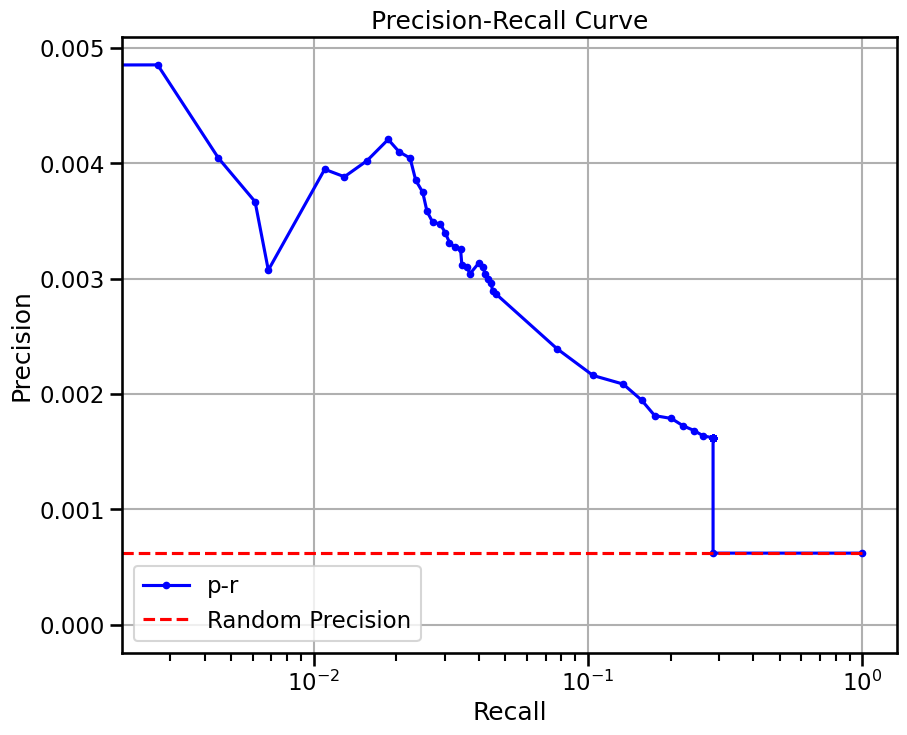

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/204 [00:00<?, ?it/s]


  0%|          | 1/204 [00:00<00:27,  7.36it/s]


  1%|          | 2/204 [00:00<00:27,  7.39it/s]


  1%|▏         | 3/204 [00:00<00:25,  7.89it/s]


  2%|▏         | 4/204 [00:00<00:24,  8.05it/s]


  2%|▏         | 5/204 [00:00<00:24,  8.23it/s]


  3%|▎         | 6/204 [00:00<00:23,  8.34it/s]


  3%|▎         | 7/204 [00:00<00:23,  8.40it/s]


  4%|▍         | 8/204 [00:00<00:23,  8.44it/s]


  4%|▍         | 9/204 [00:01<00:22,  8.48it/s]


  5%|▍         | 10/204 [00:01<00:22,  8.53it/s]


  5%|▌         | 11/204 [00:01<00:22,  8.57it/s]


  6%|▌         | 12/204 [00:01<00:22,  8.58it/s]


  6%|▋         | 13/204 [00:01<00:22,  8.60it/s]


  7%|▋         | 14/204 [00:01<00:22,  8.61it/s]


  7%|▋         | 15/204 [00:01<00:21,  8.61it/s]


  8%|▊         | 16/204 [00:01<00:21,  8.62it/s]


  8%|▊         | 17/204 [00:02<00:21,  8.63it/s]


  9%|▉         | 18/204 [00:02<00:21,  8.62it/s]


  9%|▉         | 19/204 [00:02<00:21,  8.62it/s]


 10%|▉         | 20/204 [00:02<00:21,  8.62it/s]


 10%|█         | 21/204 [00:02<00:21,  8.60it/s]


 11%|█         | 22/204 [00:02<00:21,  8.59it/s]


 11%|█▏        | 23/204 [00:02<00:21,  8.59it/s]


 12%|█▏        | 24/204 [00:02<00:20,  8.61it/s]


 12%|█▏        | 25/204 [00:02<00:20,  8.62it/s]


 13%|█▎        | 26/204 [00:03<00:20,  8.63it/s]


 13%|█▎        | 27/204 [00:03<00:20,  8.61it/s]


 14%|█▎        | 28/204 [00:03<00:20,  8.62it/s]


 14%|█▍        | 29/204 [00:03<00:20,  8.61it/s]


 15%|█▍        | 30/204 [00:03<00:20,  8.60it/s]


 15%|█▌        | 31/204 [00:03<00:20,  8.59it/s]


 16%|█▌        | 32/204 [00:03<00:20,  8.60it/s]


 16%|█▌        | 33/204 [00:03<00:19,  8.61it/s]


 17%|█▋        | 34/204 [00:03<00:19,  8.61it/s]


 17%|█▋        | 35/204 [00:04<00:19,  8.60it/s]


 18%|█▊        | 36/204 [00:04<00:19,  8.58it/s]


 18%|█▊        | 37/204 [00:04<00:19,  8.58it/s]


 19%|█▊        | 38/204 [00:04<00:19,  8.58it/s]


 19%|█▉        | 39/204 [00:04<00:19,  8.58it/s]


 20%|█▉        | 40/204 [00:04<00:19,  8.57it/s]


 20%|██        | 41/204 [00:04<00:18,  8.58it/s]


 21%|██        | 42/204 [00:04<00:18,  8.59it/s]


 21%|██        | 43/204 [00:05<00:18,  8.61it/s]


 22%|██▏       | 44/204 [00:05<00:18,  8.62it/s]


 22%|██▏       | 45/204 [00:05<00:18,  8.62it/s]


 23%|██▎       | 46/204 [00:05<00:18,  8.63it/s]


 23%|██▎       | 47/204 [00:05<00:18,  8.63it/s]


 24%|██▎       | 48/204 [00:05<00:18,  8.63it/s]


 24%|██▍       | 49/204 [00:05<00:17,  8.63it/s]


 25%|██▍       | 50/204 [00:05<00:17,  8.61it/s]


 25%|██▌       | 51/204 [00:05<00:17,  8.61it/s]


 25%|██▌       | 52/204 [00:06<00:17,  8.60it/s]


 26%|██▌       | 53/204 [00:06<00:17,  8.58it/s]


 26%|██▋       | 54/204 [00:06<00:17,  8.58it/s]


 27%|██▋       | 55/204 [00:06<00:17,  8.59it/s]


 27%|██▋       | 56/204 [00:06<00:17,  8.60it/s]


 28%|██▊       | 57/204 [00:06<00:17,  8.58it/s]


 28%|██▊       | 58/204 [00:06<00:17,  8.58it/s]


 29%|██▉       | 59/204 [00:06<00:16,  8.58it/s]


 29%|██▉       | 60/204 [00:07<00:16,  8.58it/s]


 30%|██▉       | 61/204 [00:07<00:16,  8.59it/s]


 30%|███       | 62/204 [00:07<00:16,  8.58it/s]


 31%|███       | 63/204 [00:07<00:16,  8.58it/s]


 31%|███▏      | 64/204 [00:07<00:16,  8.59it/s]


 32%|███▏      | 65/204 [00:07<00:16,  8.58it/s]


 32%|███▏      | 66/204 [00:07<00:16,  8.56it/s]


 33%|███▎      | 67/204 [00:07<00:15,  8.56it/s]


 33%|███▎      | 68/204 [00:07<00:15,  8.56it/s]


 34%|███▍      | 69/204 [00:08<00:15,  8.57it/s]


 34%|███▍      | 70/204 [00:08<00:15,  8.56it/s]


 35%|███▍      | 71/204 [00:08<00:15,  8.57it/s]


 35%|███▌      | 72/204 [00:08<00:15,  8.59it/s]


 36%|███▌      | 73/204 [00:08<00:15,  8.59it/s]


 36%|███▋      | 74/204 [00:08<00:15,  8.58it/s]


 37%|███▋      | 75/204 [00:08<00:15,  8.59it/s]


 37%|███▋      | 76/204 [00:08<00:14,  8.59it/s]


 38%|███▊      | 77/204 [00:09<00:14,  8.58it/s]


 38%|███▊      | 78/204 [00:09<00:14,  8.57it/s]


 39%|███▊      | 79/204 [00:09<00:14,  8.58it/s]


 39%|███▉      | 80/204 [00:09<00:14,  8.57it/s]


 40%|███▉      | 81/204 [00:09<00:14,  8.55it/s]


 40%|████      | 82/204 [00:09<00:14,  8.55it/s]


 41%|████      | 83/204 [00:09<00:14,  8.58it/s]


 41%|████      | 84/204 [00:09<00:13,  8.58it/s]


 42%|████▏     | 85/204 [00:09<00:13,  8.58it/s]


 42%|████▏     | 86/204 [00:10<00:13,  8.59it/s]


 43%|████▎     | 87/204 [00:10<00:13,  8.60it/s]


 43%|████▎     | 88/204 [00:10<00:13,  8.60it/s]


 44%|████▎     | 89/204 [00:10<00:13,  8.61it/s]


 44%|████▍     | 90/204 [00:10<00:13,  8.62it/s]


 45%|████▍     | 91/204 [00:10<00:13,  8.63it/s]


 45%|████▌     | 92/204 [00:10<00:12,  8.62it/s]


 46%|████▌     | 93/204 [00:10<00:12,  8.62it/s]


 46%|████▌     | 94/204 [00:10<00:12,  8.62it/s]


 47%|████▋     | 95/204 [00:11<00:12,  8.62it/s]


 47%|████▋     | 96/204 [00:11<00:12,  8.62it/s]


 48%|████▊     | 97/204 [00:11<00:12,  8.62it/s]


 48%|████▊     | 98/204 [00:11<00:12,  8.63it/s]


 49%|████▊     | 99/204 [00:11<00:12,  8.63it/s]


 49%|████▉     | 100/204 [00:11<00:12,  8.62it/s]


 50%|████▉     | 101/204 [00:11<00:11,  8.63it/s]


 50%|█████     | 102/204 [00:11<00:11,  8.62it/s]


 50%|█████     | 103/204 [00:12<00:11,  8.61it/s]


 51%|█████     | 104/204 [00:12<00:11,  8.61it/s]


 51%|█████▏    | 105/204 [00:12<00:11,  8.61it/s]


 52%|█████▏    | 106/204 [00:12<00:11,  8.61it/s]


 52%|█████▏    | 107/204 [00:12<00:11,  8.60it/s]


 53%|█████▎    | 108/204 [00:12<00:11,  8.61it/s]


 53%|█████▎    | 109/204 [00:12<00:11,  8.62it/s]


 54%|█████▍    | 110/204 [00:12<00:10,  8.62it/s]


 54%|█████▍    | 111/204 [00:12<00:10,  8.61it/s]


 55%|█████▍    | 112/204 [00:13<00:10,  8.62it/s]


 55%|█████▌    | 113/204 [00:13<00:10,  8.62it/s]


 56%|█████▌    | 114/204 [00:13<00:10,  8.62it/s]


 56%|█████▋    | 115/204 [00:13<00:10,  8.62it/s]


 57%|█████▋    | 116/204 [00:13<00:10,  8.62it/s]


 57%|█████▋    | 117/204 [00:13<00:10,  8.63it/s]


 58%|█████▊    | 118/204 [00:13<00:09,  8.63it/s]


 58%|█████▊    | 119/204 [00:13<00:09,  8.63it/s]


 59%|█████▉    | 120/204 [00:13<00:09,  8.63it/s]


 59%|█████▉    | 121/204 [00:14<00:09,  8.63it/s]


 60%|█████▉    | 122/204 [00:14<00:09,  8.63it/s]


 60%|██████    | 123/204 [00:14<00:09,  8.63it/s]


 61%|██████    | 124/204 [00:14<00:09,  8.61it/s]


 61%|██████▏   | 125/204 [00:14<00:09,  8.59it/s]


 62%|██████▏   | 126/204 [00:14<00:09,  8.59it/s]


 62%|██████▏   | 127/204 [00:14<00:08,  8.59it/s]


 63%|██████▎   | 128/204 [00:14<00:08,  8.58it/s]


 63%|██████▎   | 129/204 [00:15<00:08,  8.58it/s]


 64%|██████▎   | 130/204 [00:15<00:08,  8.59it/s]


 64%|██████▍   | 131/204 [00:15<00:08,  8.59it/s]


 65%|██████▍   | 132/204 [00:15<00:08,  8.59it/s]


 65%|██████▌   | 133/204 [00:15<00:08,  8.58it/s]


 66%|██████▌   | 134/204 [00:15<00:08,  8.58it/s]


 66%|██████▌   | 135/204 [00:15<00:08,  8.57it/s]


 67%|██████▋   | 136/204 [00:15<00:07,  8.58it/s]


 67%|██████▋   | 137/204 [00:15<00:07,  8.57it/s]


 68%|██████▊   | 138/204 [00:16<00:07,  8.58it/s]


 68%|██████▊   | 139/204 [00:16<00:07,  8.58it/s]


 69%|██████▊   | 140/204 [00:16<00:07,  8.59it/s]


 69%|██████▉   | 141/204 [00:16<00:07,  8.60it/s]


 70%|██████▉   | 142/204 [00:16<00:07,  8.61it/s]


 70%|███████   | 143/204 [00:16<00:07,  8.62it/s]


 71%|███████   | 144/204 [00:16<00:06,  8.62it/s]


 71%|███████   | 145/204 [00:16<00:06,  8.63it/s]


 72%|███████▏  | 146/204 [00:17<00:06,  8.63it/s]


 72%|███████▏  | 147/204 [00:17<00:06,  8.63it/s]


 73%|███████▎  | 148/204 [00:17<00:06,  8.63it/s]


 73%|███████▎  | 149/204 [00:17<00:06,  8.63it/s]


 74%|███████▎  | 150/204 [00:17<00:06,  8.62it/s]


 74%|███████▍  | 151/204 [00:17<00:06,  8.62it/s]


 75%|███████▍  | 152/204 [00:17<00:06,  8.62it/s]


 75%|███████▌  | 153/204 [00:17<00:05,  8.62it/s]


 75%|███████▌  | 154/204 [00:17<00:05,  8.61it/s]


 76%|███████▌  | 155/204 [00:18<00:05,  8.62it/s]


 76%|███████▋  | 156/204 [00:18<00:05,  8.61it/s]


 77%|███████▋  | 157/204 [00:18<00:05,  8.60it/s]


 77%|███████▋  | 158/204 [00:18<00:05,  8.61it/s]


 78%|███████▊  | 159/204 [00:18<00:05,  8.62it/s]


 78%|███████▊  | 160/204 [00:18<00:05,  8.62it/s]


 79%|███████▉  | 161/204 [00:18<00:04,  8.62it/s]


 79%|███████▉  | 162/204 [00:18<00:04,  8.61it/s]


 80%|███████▉  | 163/204 [00:18<00:04,  8.61it/s]


 80%|████████  | 164/204 [00:19<00:04,  8.62it/s]


 81%|████████  | 165/204 [00:19<00:04,  8.62it/s]


 81%|████████▏ | 166/204 [00:19<00:04,  8.62it/s]


 82%|████████▏ | 167/204 [00:19<00:04,  8.62it/s]


 82%|████████▏ | 168/204 [00:19<00:04,  8.62it/s]


 83%|████████▎ | 169/204 [00:19<00:04,  8.63it/s]


 83%|████████▎ | 170/204 [00:19<00:03,  8.62it/s]


 84%|████████▍ | 171/204 [00:19<00:03,  8.62it/s]


 84%|████████▍ | 172/204 [00:20<00:03,  8.60it/s]


 85%|████████▍ | 173/204 [00:20<00:03,  8.60it/s]


 85%|████████▌ | 174/204 [00:20<00:03,  8.61it/s]


 86%|████████▌ | 175/204 [00:20<00:03,  8.62it/s]


 86%|████████▋ | 176/204 [00:20<00:03,  8.62it/s]


 87%|████████▋ | 177/204 [00:20<00:03,  8.63it/s]


 87%|████████▋ | 178/204 [00:20<00:03,  8.62it/s]


 88%|████████▊ | 179/204 [00:20<00:02,  8.61it/s]


 88%|████████▊ | 180/204 [00:20<00:02,  8.62it/s]


 89%|████████▊ | 181/204 [00:21<00:02,  8.61it/s]


 89%|████████▉ | 182/204 [00:21<00:02,  8.60it/s]


 90%|████████▉ | 183/204 [00:21<00:02,  8.60it/s]


 90%|█████████ | 184/204 [00:21<00:02,  8.60it/s]


 91%|█████████ | 185/204 [00:21<00:02,  8.61it/s]


 91%|█████████ | 186/204 [00:21<00:02,  8.62it/s]


 92%|█████████▏| 187/204 [00:21<00:01,  8.62it/s]


 92%|█████████▏| 188/204 [00:21<00:01,  8.62it/s]


 93%|█████████▎| 189/204 [00:22<00:01,  8.62it/s]


 93%|█████████▎| 190/204 [00:22<00:01,  8.62it/s]


 94%|█████████▎| 191/204 [00:22<00:01,  8.61it/s]


 94%|█████████▍| 192/204 [00:22<00:01,  8.61it/s]


 95%|█████████▍| 193/204 [00:22<00:01,  8.60it/s]


 95%|█████████▌| 194/204 [00:22<00:01,  8.61it/s]


 96%|█████████▌| 195/204 [00:22<00:01,  8.62it/s]


 96%|█████████▌| 196/204 [00:22<00:00,  8.62it/s]


 97%|█████████▋| 197/204 [00:22<00:00,  8.63it/s]


 97%|█████████▋| 198/204 [00:23<00:00,  8.63it/s]


 98%|█████████▊| 199/204 [00:23<00:00,  8.62it/s]


 98%|█████████▊| 200/204 [00:23<00:00,  8.62it/s]


 99%|█████████▊| 201/204 [00:23<00:00,  8.62it/s]


 99%|█████████▉| 202/204 [00:23<00:00,  8.62it/s]


100%|█████████▉| 203/204 [00:23<00:00,  8.62it/s]


100%|██████████| 204/204 [00:23<00:00,  8.60it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


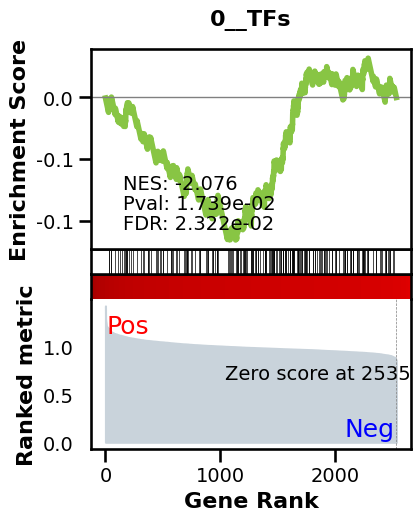

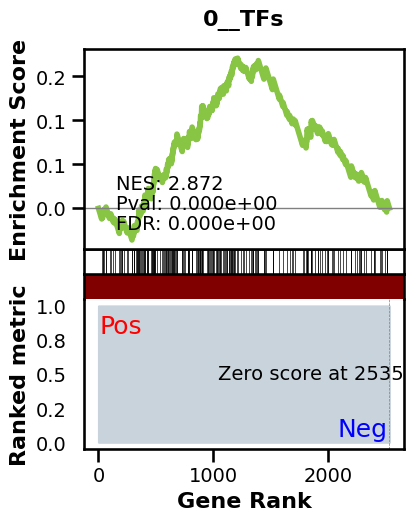

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1735 genes
intersection pct: 0.6841482649842271
precision:  0.0009866372115041235 
recall:  1.0 
random precision: 0.0009872062064357867



  0%|          | 0/128 [00:00<?, ?it/s]


 22%|██▏       | 28/128 [00:00<00:00, 270.61it/s]


 44%|████▍     | 56/128 [00:00<00:00, 269.64it/s]


 66%|██████▌   | 84/128 [00:00<00:00, 270.01it/s]


 88%|████████▊ | 112/128 [00:00<00:00, 270.18it/s]


100%|██████████| 128/128 [00:00<00:00, 269.74it/s]

Average Precision (AP):  0.0011776370263287578
Area Under Precision-Recall Curve (AUPRC):  0.0011751490467923247
EPR: 0.0


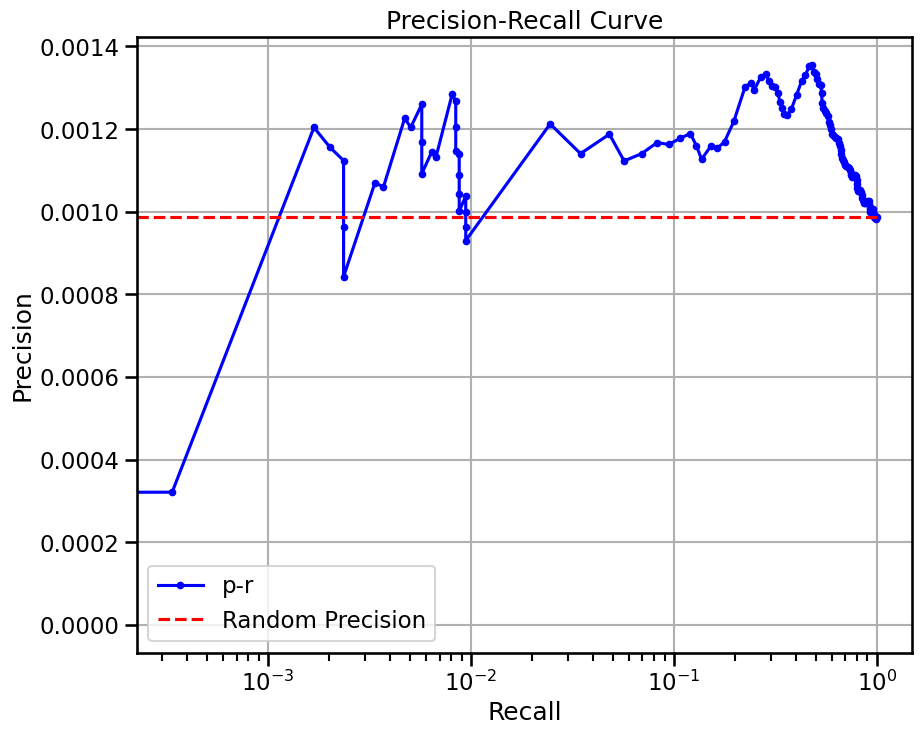

base enrichment


Top central genes: []


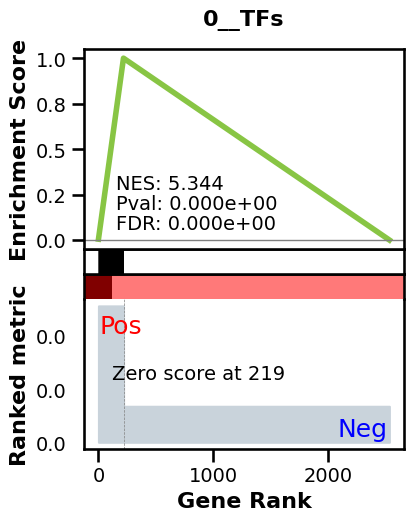

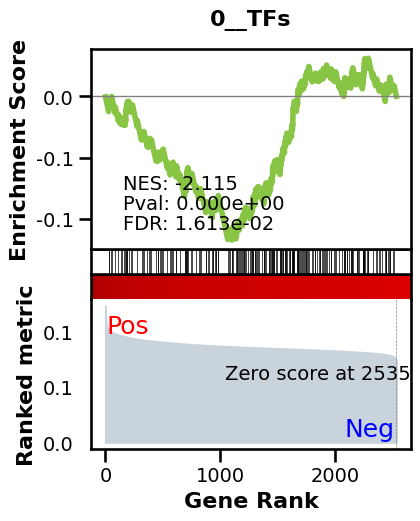

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1735 genes
intersection pct: 0.6841482649842271
precision:  0.0037103746397694525 
recall:  0.4161616161616162 
random precision: 0.0009872062064357867



  0%|          | 0/128 [00:00<?, ?it/s]


 21%|██        | 27/128 [00:00<00:00, 264.56it/s]


 42%|████▏     | 54/128 [00:00<00:00, 266.95it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 266.76it/s]


 84%|████████▍ | 108/128 [00:00<00:00, 267.82it/s]


100%|██████████| 128/128 [00:00<00:00, 267.08it/s]

Average Precision (AP):  0.002998390805049126
Area Under Precision-Recall Curve (AUPRC):  0.002601713280410021
EPR: 6.551008732831664


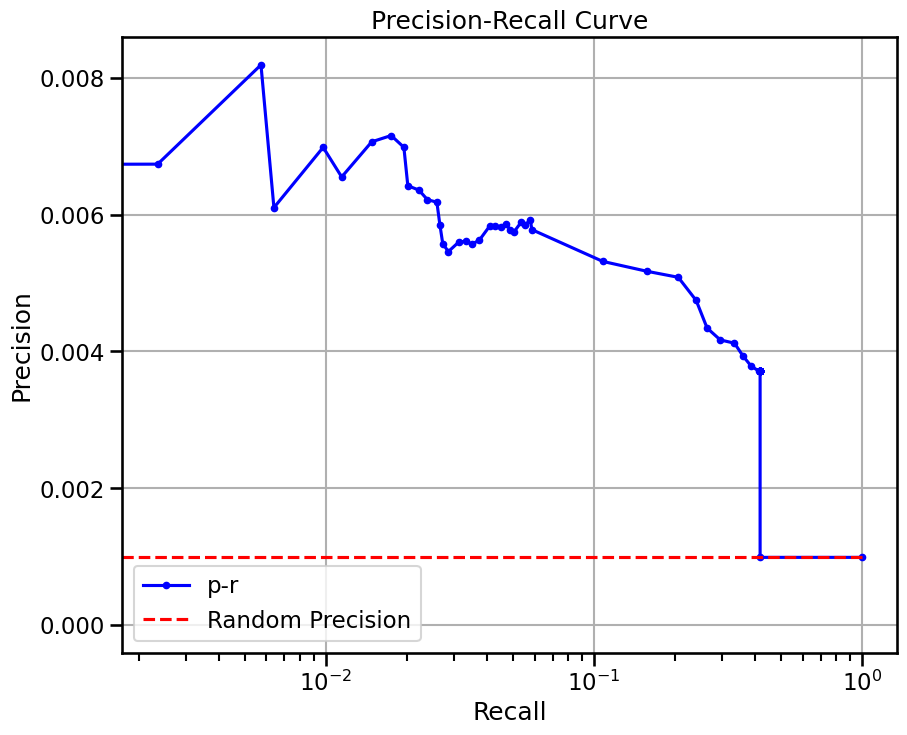

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/154 [00:00<?, ?it/s]


  1%|          | 1/154 [00:00<00:36,  4.22it/s]


  1%|▏         | 2/154 [00:00<00:32,  4.66it/s]


  2%|▏         | 3/154 [00:00<00:32,  4.70it/s]


  3%|▎         | 4/154 [00:00<00:30,  4.87it/s]


  3%|▎         | 5/154 [00:01<00:30,  4.83it/s]


  4%|▍         | 6/154 [00:01<00:29,  4.94it/s]


  5%|▍         | 7/154 [00:01<00:30,  4.83it/s]


  5%|▌         | 8/154 [00:01<00:29,  4.93it/s]


  6%|▌         | 9/154 [00:01<00:29,  4.88it/s]


  6%|▋         | 10/154 [00:02<00:29,  4.96it/s]


  7%|▋         | 11/154 [00:02<00:29,  4.90it/s]


  8%|▊         | 12/154 [00:02<00:28,  4.97it/s]


  8%|▊         | 13/154 [00:02<00:28,  4.91it/s]


  9%|▉         | 14/154 [00:02<00:28,  4.98it/s]


 10%|▉         | 15/154 [00:03<00:28,  4.92it/s]


 10%|█         | 16/154 [00:03<00:27,  4.99it/s]


 11%|█         | 17/154 [00:03<00:27,  4.92it/s]


 12%|█▏        | 18/154 [00:03<00:27,  4.99it/s]


 12%|█▏        | 19/154 [00:03<00:27,  4.92it/s]


 13%|█▎        | 20/154 [00:04<00:26,  4.98it/s]


 14%|█▎        | 21/154 [00:04<00:27,  4.92it/s]


 14%|█▍        | 22/154 [00:04<00:26,  4.98it/s]


 15%|█▍        | 23/154 [00:04<00:26,  4.92it/s]


 16%|█▌        | 24/154 [00:04<00:26,  4.98it/s]


 16%|█▌        | 25/154 [00:05<00:26,  4.92it/s]


 17%|█▋        | 26/154 [00:05<00:25,  4.98it/s]


 18%|█▊        | 27/154 [00:05<00:25,  4.91it/s]


 18%|█▊        | 28/154 [00:05<00:25,  4.98it/s]


 19%|█▉        | 29/154 [00:05<00:25,  4.91it/s]


 19%|█▉        | 30/154 [00:06<00:24,  4.98it/s]


 20%|██        | 31/154 [00:06<00:25,  4.91it/s]


 21%|██        | 32/154 [00:06<00:24,  4.98it/s]


 21%|██▏       | 33/154 [00:06<00:24,  4.91it/s]


 22%|██▏       | 34/154 [00:06<00:24,  4.98it/s]


 23%|██▎       | 35/154 [00:07<00:24,  4.91it/s]


 23%|██▎       | 36/154 [00:07<00:23,  4.98it/s]


 24%|██▍       | 37/154 [00:07<00:23,  4.91it/s]


 25%|██▍       | 38/154 [00:07<00:23,  4.98it/s]


 25%|██▌       | 39/154 [00:07<00:23,  4.91it/s]


 26%|██▌       | 40/154 [00:08<00:22,  4.98it/s]


 27%|██▋       | 41/154 [00:08<00:22,  4.92it/s]


 27%|██▋       | 42/154 [00:08<00:22,  4.98it/s]


 28%|██▊       | 43/154 [00:08<00:22,  4.92it/s]


 29%|██▊       | 44/154 [00:08<00:22,  4.98it/s]


 29%|██▉       | 45/154 [00:09<00:22,  4.92it/s]


 30%|██▉       | 46/154 [00:09<00:21,  4.98it/s]


 31%|███       | 47/154 [00:09<00:21,  4.92it/s]


 31%|███       | 48/154 [00:09<00:21,  4.98it/s]


 32%|███▏      | 49/154 [00:09<00:21,  4.91it/s]


 32%|███▏      | 50/154 [00:10<00:20,  4.98it/s]


 33%|███▎      | 51/154 [00:10<00:20,  4.91it/s]


 34%|███▍      | 52/154 [00:10<00:20,  4.97it/s]


 34%|███▍      | 53/154 [00:10<00:20,  4.91it/s]


 35%|███▌      | 54/154 [00:10<00:20,  4.98it/s]


 36%|███▌      | 55/154 [00:11<00:20,  4.91it/s]


 36%|███▋      | 56/154 [00:11<00:19,  4.97it/s]


 37%|███▋      | 57/154 [00:11<00:19,  4.91it/s]


 38%|███▊      | 58/154 [00:11<00:19,  4.98it/s]


 38%|███▊      | 59/154 [00:11<00:19,  4.91it/s]


 39%|███▉      | 60/154 [00:12<00:18,  4.98it/s]


 40%|███▉      | 61/154 [00:12<00:19,  4.87it/s]


 40%|████      | 62/154 [00:12<00:18,  4.94it/s]


 41%|████      | 63/154 [00:12<00:18,  4.89it/s]


 42%|████▏     | 64/154 [00:12<00:18,  4.96it/s]


 42%|████▏     | 65/154 [00:13<00:18,  4.90it/s]


 43%|████▎     | 66/154 [00:13<00:17,  4.96it/s]


 44%|████▎     | 67/154 [00:13<00:17,  4.90it/s]


 44%|████▍     | 68/154 [00:13<00:17,  4.97it/s]


 45%|████▍     | 69/154 [00:14<00:17,  4.91it/s]


 45%|████▌     | 70/154 [00:14<00:16,  4.97it/s]


 46%|████▌     | 71/154 [00:14<00:16,  4.91it/s]


 47%|████▋     | 72/154 [00:14<00:16,  4.97it/s]


 47%|████▋     | 73/154 [00:14<00:16,  4.91it/s]


 48%|████▊     | 74/154 [00:15<00:16,  4.98it/s]


 49%|████▊     | 75/154 [00:15<00:16,  4.91it/s]


 49%|████▉     | 76/154 [00:15<00:15,  4.97it/s]


 50%|█████     | 77/154 [00:15<00:15,  4.91it/s]


 51%|█████     | 78/154 [00:15<00:15,  4.97it/s]


 51%|█████▏    | 79/154 [00:16<00:15,  4.91it/s]


 52%|█████▏    | 80/154 [00:16<00:15,  4.88it/s]


 53%|█████▎    | 81/154 [00:16<00:15,  4.84it/s]


 53%|█████▎    | 82/154 [00:16<00:14,  4.93it/s]


 54%|█████▍    | 83/154 [00:16<00:14,  4.88it/s]


 55%|█████▍    | 84/154 [00:17<00:14,  4.94it/s]


 55%|█████▌    | 85/154 [00:17<00:14,  4.89it/s]


 56%|█████▌    | 86/154 [00:17<00:13,  4.96it/s]


 56%|█████▋    | 87/154 [00:17<00:13,  4.90it/s]


 57%|█████▋    | 88/154 [00:17<00:13,  4.97it/s]


 58%|█████▊    | 89/154 [00:18<00:13,  4.90it/s]


 58%|█████▊    | 90/154 [00:18<00:12,  4.97it/s]


 59%|█████▉    | 91/154 [00:18<00:12,  4.91it/s]


 60%|█████▉    | 92/154 [00:18<00:12,  4.97it/s]


 60%|██████    | 93/154 [00:18<00:12,  4.91it/s]


 61%|██████    | 94/154 [00:19<00:12,  4.97it/s]


 62%|██████▏   | 95/154 [00:19<00:12,  4.91it/s]


 62%|██████▏   | 96/154 [00:19<00:11,  4.97it/s]


 63%|██████▎   | 97/154 [00:19<00:11,  4.91it/s]


 64%|██████▎   | 98/154 [00:19<00:11,  4.92it/s]


 64%|██████▍   | 99/154 [00:20<00:11,  4.85it/s]


 65%|██████▍   | 100/154 [00:20<00:10,  4.91it/s]


 66%|██████▌   | 101/154 [00:20<00:10,  4.82it/s]


 66%|██████▌   | 102/154 [00:20<00:10,  4.91it/s]


 67%|██████▋   | 103/154 [00:20<00:10,  4.87it/s]


 68%|██████▊   | 104/154 [00:21<00:10,  4.94it/s]


 68%|██████▊   | 105/154 [00:21<00:10,  4.89it/s]


 69%|██████▉   | 106/154 [00:21<00:09,  4.96it/s]


 69%|██████▉   | 107/154 [00:21<00:09,  4.90it/s]


 70%|███████   | 108/154 [00:21<00:09,  4.97it/s]


 71%|███████   | 109/154 [00:22<00:09,  4.91it/s]


 71%|███████▏  | 110/154 [00:22<00:08,  4.97it/s]


 72%|███████▏  | 111/154 [00:22<00:08,  4.91it/s]


 73%|███████▎  | 112/154 [00:22<00:08,  4.98it/s]


 73%|███████▎  | 113/154 [00:22<00:08,  4.91it/s]


 74%|███████▍  | 114/154 [00:23<00:08,  4.97it/s]


 75%|███████▍  | 115/154 [00:23<00:08,  4.73it/s]


 75%|███████▌  | 116/154 [00:23<00:07,  4.84it/s]


 76%|███████▌  | 117/154 [00:23<00:07,  4.82it/s]


 77%|███████▋  | 118/154 [00:23<00:07,  4.91it/s]


 77%|███████▋  | 119/154 [00:24<00:07,  4.86it/s]


 78%|███████▊  | 120/154 [00:24<00:06,  4.94it/s]


 79%|███████▊  | 121/154 [00:24<00:06,  4.84it/s]


 79%|███████▉  | 122/154 [00:24<00:06,  4.92it/s]


 80%|███████▉  | 123/154 [00:24<00:06,  4.88it/s]


 81%|████████  | 124/154 [00:25<00:06,  4.95it/s]


 81%|████████  | 125/154 [00:25<00:05,  4.89it/s]


 82%|████████▏ | 126/154 [00:25<00:05,  4.95it/s]


 82%|████████▏ | 127/154 [00:25<00:05,  4.90it/s]


 83%|████████▎ | 128/154 [00:26<00:05,  4.96it/s]


 84%|████████▍ | 129/154 [00:26<00:05,  4.90it/s]


 84%|████████▍ | 130/154 [00:26<00:04,  4.97it/s]


 85%|████████▌ | 131/154 [00:26<00:04,  4.91it/s]


 86%|████████▌ | 132/154 [00:26<00:04,  4.97it/s]


 86%|████████▋ | 133/154 [00:27<00:04,  4.91it/s]


 87%|████████▋ | 134/154 [00:27<00:04,  4.97it/s]


 88%|████████▊ | 135/154 [00:27<00:03,  4.91it/s]


 88%|████████▊ | 136/154 [00:27<00:03,  4.97it/s]


 89%|████████▉ | 137/154 [00:27<00:03,  4.91it/s]


 90%|████████▉ | 138/154 [00:28<00:03,  4.97it/s]


 90%|█████████ | 139/154 [00:28<00:03,  4.90it/s]


 91%|█████████ | 140/154 [00:28<00:02,  4.97it/s]


 92%|█████████▏| 141/154 [00:28<00:02,  4.90it/s]


 92%|█████████▏| 142/154 [00:28<00:02,  4.97it/s]


 93%|█████████▎| 143/154 [00:29<00:02,  4.90it/s]


 94%|█████████▎| 144/154 [00:29<00:02,  4.97it/s]


 94%|█████████▍| 145/154 [00:29<00:01,  4.90it/s]


 95%|█████████▍| 146/154 [00:29<00:01,  4.97it/s]


 95%|█████████▌| 147/154 [00:29<00:01,  4.90it/s]


 96%|█████████▌| 148/154 [00:30<00:01,  4.97it/s]


 97%|█████████▋| 149/154 [00:30<00:01,  4.90it/s]


 97%|█████████▋| 150/154 [00:30<00:00,  4.97it/s]


 98%|█████████▊| 151/154 [00:30<00:00,  4.90it/s]


 99%|█████████▊| 152/154 [00:30<00:00,  4.97it/s]


 99%|█████████▉| 153/154 [00:31<00:00,  4.90it/s]


100%|██████████| 154/154 [00:31<00:00,  4.96it/s]


100%|██████████| 154/154 [00:31<00:00,  4.92it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


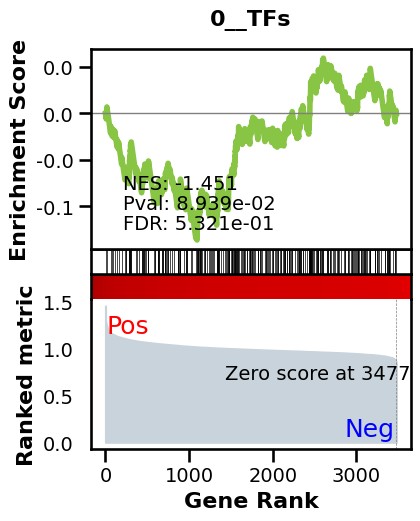

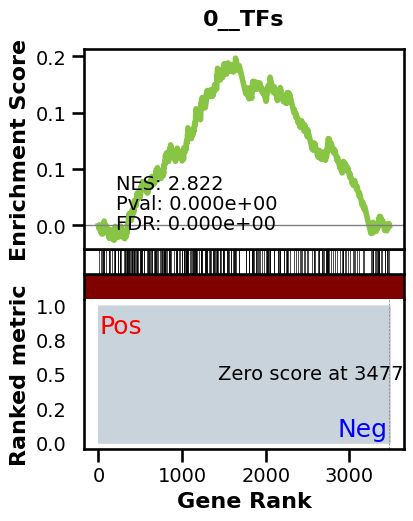

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2451 genes
intersection pct: 0.7047153536515238
precision:  0.0011692244283343163 
recall:  1.0 
random precision: 0.0011697016627948609



  0%|          | 0/128 [00:00<?, ?it/s]


 10%|█         | 13/128 [00:00<00:00, 120.68it/s]


 20%|██        | 26/128 [00:00<00:00, 120.53it/s]


 30%|███       | 39/128 [00:00<00:00, 120.36it/s]


 41%|████      | 52/128 [00:00<00:00, 120.46it/s]


 51%|█████     | 65/128 [00:00<00:00, 120.38it/s]


 61%|██████    | 78/128 [00:00<00:00, 120.09it/s]


 71%|███████   | 91/128 [00:00<00:00, 120.49it/s]


 81%|████████▏ | 104/128 [00:00<00:00, 120.56it/s]


 91%|█████████▏| 117/128 [00:00<00:00, 120.36it/s]


100%|██████████| 128/128 [00:01<00:00, 120.43it/s]

Average Precision (AP):  0.0013166742386339222
Area Under Precision-Recall Curve (AUPRC):  0.0013159448022350818
EPR: 0.3645992252960126


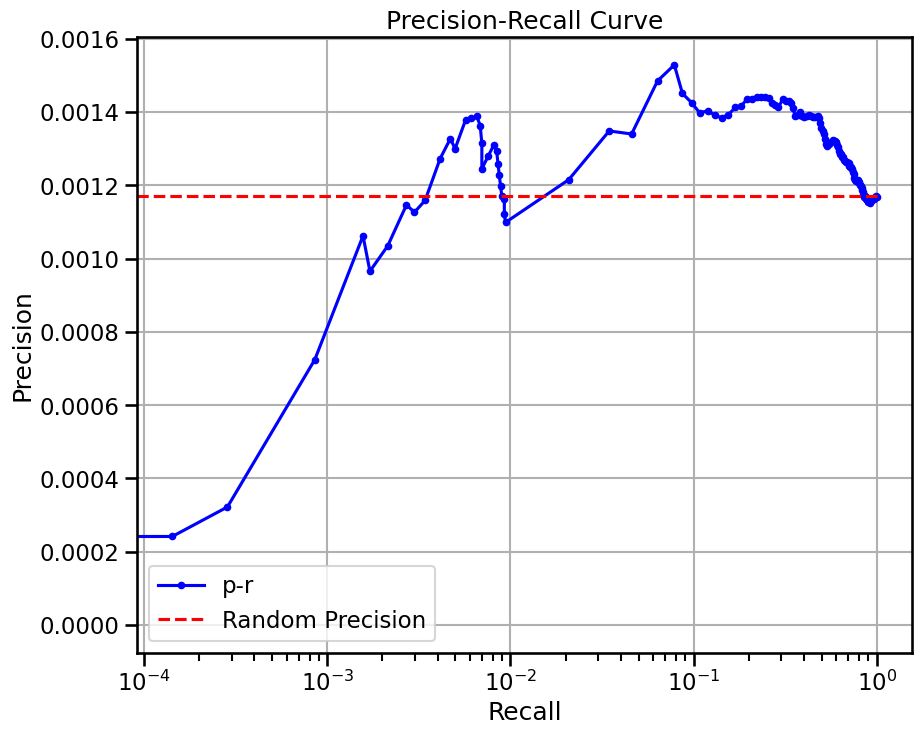

base enrichment


Top central genes: []


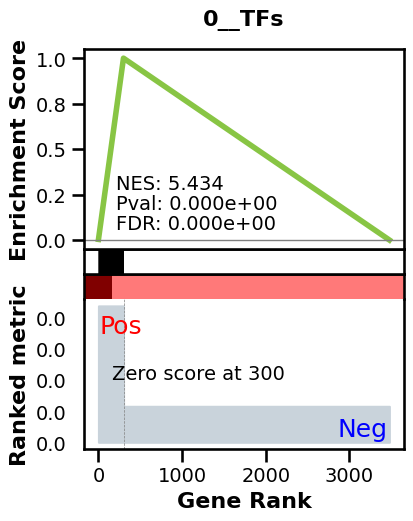

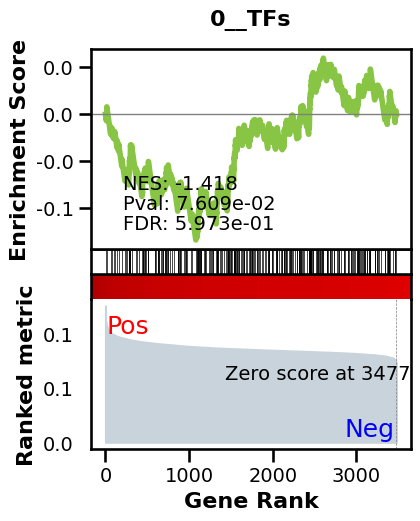

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2451 genes
intersection pct: 0.7047153536515238
precision:  0.005551955584355325 
recall:  0.4940205011389522 
random precision: 0.0011697016627948609



  0%|          | 0/128 [00:00<?, ?it/s]


  9%|▉         | 12/128 [00:00<00:00, 118.71it/s]


 20%|█▉        | 25/128 [00:00<00:00, 119.97it/s]


 29%|██▉       | 37/128 [00:00<00:00, 119.63it/s]


 39%|███▉      | 50/128 [00:00<00:00, 119.88it/s]


 49%|████▉     | 63/128 [00:00<00:00, 120.36it/s]


 59%|█████▉    | 76/128 [00:00<00:00, 120.63it/s]


 70%|██████▉   | 89/128 [00:00<00:00, 120.66it/s]


 80%|███████▉  | 102/128 [00:00<00:00, 120.62it/s]


 90%|████████▉ | 115/128 [00:00<00:00, 120.68it/s]


100%|██████████| 128/128 [00:01<00:00, 120.77it/s]


100%|██████████| 128/128 [00:01<00:00, 120.38it/s]

Average Precision (AP):  0.004385162813984027
Area Under Precision-Recall Curve (AUPRC):  0.003992007606739482
EPR: 7.035250764595108


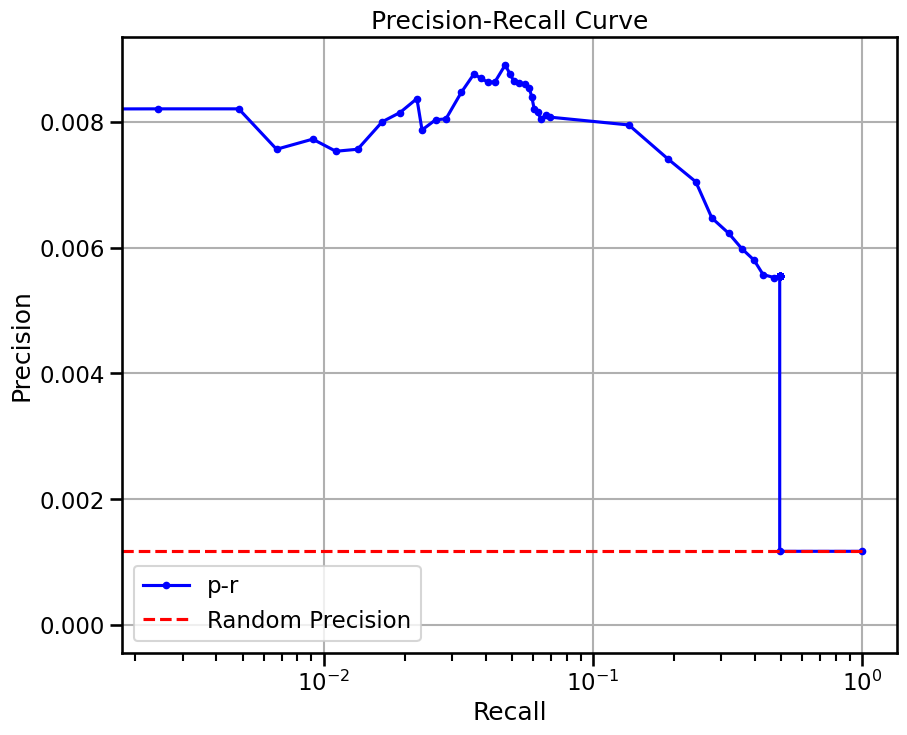

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/74 [00:00<?, ?it/s]


  1%|▏         | 1/74 [00:00<00:28,  2.60it/s]


  3%|▎         | 2/74 [00:00<00:25,  2.85it/s]


  4%|▍         | 3/74 [00:01<00:25,  2.80it/s]


  5%|▌         | 4/74 [00:01<00:24,  2.90it/s]


  7%|▋         | 5/74 [00:01<00:24,  2.85it/s]


  8%|▊         | 6/74 [00:02<00:23,  2.92it/s]


  9%|▉         | 7/74 [00:02<00:23,  2.86it/s]


 11%|█         | 8/74 [00:02<00:22,  2.92it/s]


 12%|█▏        | 9/74 [00:03<00:21,  2.97it/s]


 14%|█▎        | 10/74 [00:03<00:22,  2.90it/s]


 15%|█▍        | 11/74 [00:03<00:21,  2.94it/s]


 16%|█▌        | 12/74 [00:04<00:21,  2.88it/s]


 18%|█▊        | 13/74 [00:04<00:20,  2.94it/s]


 19%|█▉        | 14/74 [00:04<00:20,  2.88it/s]


 20%|██        | 15/74 [00:05<00:20,  2.93it/s]


 22%|██▏       | 16/74 [00:05<00:20,  2.87it/s]


 23%|██▎       | 17/74 [00:05<00:19,  2.93it/s]


 24%|██▍       | 18/74 [00:06<00:18,  2.96it/s]


 26%|██▌       | 19/74 [00:06<00:18,  2.99it/s]


 27%|██▋       | 20/74 [00:06<00:17,  3.01it/s]


 28%|██▊       | 21/74 [00:07<00:17,  3.03it/s]


 30%|██▉       | 22/74 [00:07<00:17,  3.03it/s]


 31%|███       | 23/74 [00:07<00:16,  3.04it/s]


 32%|███▏      | 24/74 [00:08<00:16,  3.05it/s]


 34%|███▍      | 25/74 [00:08<00:16,  3.05it/s]


 35%|███▌      | 26/74 [00:08<00:15,  3.05it/s]


 36%|███▋      | 27/74 [00:09<00:15,  3.05it/s]


 38%|███▊      | 28/74 [00:09<00:15,  3.05it/s]


 39%|███▉      | 29/74 [00:09<00:14,  3.02it/s]


 41%|████      | 30/74 [00:10<00:14,  3.03it/s]


 42%|████▏     | 31/74 [00:10<00:14,  3.04it/s]


 43%|████▎     | 32/74 [00:10<00:13,  3.01it/s]


 45%|████▍     | 33/74 [00:11<00:13,  3.02it/s]


 46%|████▌     | 34/74 [00:11<00:13,  3.03it/s]


 47%|████▋     | 35/74 [00:11<00:12,  3.04it/s]


 49%|████▊     | 36/74 [00:12<00:12,  3.04it/s]


 50%|█████     | 37/74 [00:12<00:12,  3.05it/s]


 51%|█████▏    | 38/74 [00:12<00:11,  3.05it/s]


 53%|█████▎    | 39/74 [00:13<00:11,  3.05it/s]


 54%|█████▍    | 40/74 [00:13<00:11,  3.02it/s]


 55%|█████▌    | 41/74 [00:13<00:10,  3.03it/s]


 57%|█████▋    | 42/74 [00:14<00:11,  2.88it/s]


 58%|█████▊    | 43/74 [00:14<00:10,  2.93it/s]


 59%|█████▉    | 44/74 [00:14<00:10,  2.97it/s]


 61%|██████    | 45/74 [00:15<00:10,  2.90it/s]


 62%|██████▏   | 46/74 [00:15<00:09,  2.95it/s]


 64%|██████▎   | 47/74 [00:15<00:09,  2.98it/s]


 65%|██████▍   | 48/74 [00:16<00:08,  3.00it/s]


 66%|██████▌   | 49/74 [00:16<00:08,  3.02it/s]


 68%|██████▊   | 50/74 [00:16<00:07,  3.03it/s]


 69%|██████▉   | 51/74 [00:17<00:07,  3.04it/s]


 70%|███████   | 52/74 [00:17<00:07,  3.04it/s]


 72%|███████▏  | 53/74 [00:17<00:06,  3.02it/s]


 73%|███████▎  | 54/74 [00:18<00:06,  3.03it/s]


 74%|███████▍  | 55/74 [00:18<00:06,  3.04it/s]


 76%|███████▌  | 56/74 [00:18<00:05,  3.04it/s]


 77%|███████▋  | 57/74 [00:19<00:05,  3.05it/s]


 78%|███████▊  | 58/74 [00:19<00:05,  3.05it/s]


 80%|███████▉  | 59/74 [00:19<00:04,  3.05it/s]


 81%|████████  | 60/74 [00:20<00:04,  3.05it/s]


 82%|████████▏ | 61/74 [00:20<00:04,  3.05it/s]


 84%|████████▍ | 62/74 [00:20<00:03,  3.05it/s]


 85%|████████▌ | 63/74 [00:21<00:03,  3.05it/s]


 86%|████████▋ | 64/74 [00:21<00:03,  3.05it/s]


 88%|████████▊ | 65/74 [00:21<00:02,  3.05it/s]


 89%|████████▉ | 66/74 [00:22<00:02,  2.95it/s]


 91%|█████████ | 67/74 [00:22<00:02,  2.98it/s]


 92%|█████████▏| 68/74 [00:22<00:01,  3.01it/s]


 93%|█████████▎| 69/74 [00:23<00:01,  2.92it/s]


 95%|█████████▍| 70/74 [00:23<00:01,  2.96it/s]


 96%|█████████▌| 71/74 [00:23<00:01,  2.89it/s]


 97%|█████████▋| 72/74 [00:24<00:00,  2.94it/s]


 99%|█████████▊| 73/74 [00:24<00:00,  2.88it/s]


100%|██████████| 74/74 [00:24<00:00,  3.01it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


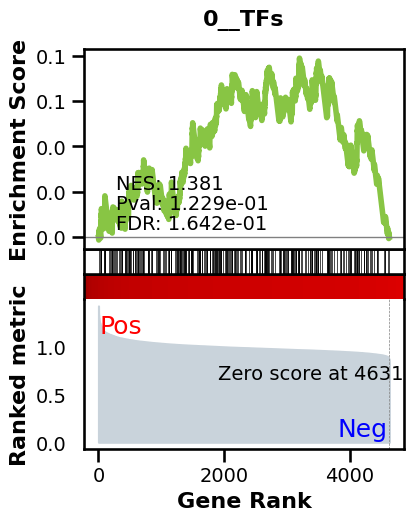

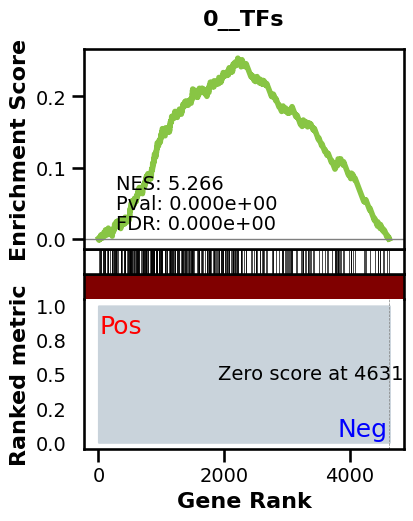

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3263 genes
intersection pct: 0.7044473229706391
precision:  0.0010702375438954711 
recall:  1.0 
random precision: 0.001070565636336886



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▌         | 7/128 [00:00<00:01, 68.23it/s]


 11%|█         | 14/128 [00:00<00:01, 68.41it/s]


 16%|█▋        | 21/128 [00:00<00:01, 68.51it/s]


 22%|██▏       | 28/128 [00:00<00:01, 68.33it/s]


 27%|██▋       | 35/128 [00:00<00:01, 68.36it/s]


 33%|███▎      | 42/128 [00:00<00:01, 68.39it/s]


 38%|███▊      | 49/128 [00:00<00:01, 68.44it/s]


 44%|████▍     | 56/128 [00:00<00:01, 68.35it/s]


 49%|████▉     | 63/128 [00:00<00:00, 68.36it/s]


 55%|█████▍    | 70/128 [00:01<00:00, 68.36it/s]


 60%|██████    | 77/128 [00:01<00:00, 68.23it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 68.27it/s]


 71%|███████   | 91/128 [00:01<00:00, 68.20it/s]


 77%|███████▋  | 98/128 [00:01<00:00, 68.32it/s]


 82%|████████▏ | 105/128 [00:01<00:00, 68.29it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 68.32it/s]


 93%|█████████▎| 119/128 [00:01<00:00, 68.43it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 68.24it/s]


100%|██████████| 128/128 [00:01<00:00, 68.30it/s]

Average Precision (AP):  0.0011763453164949614
Area Under Precision-Recall Curve (AUPRC):  0.001176060287875858
EPR: 2.1364858961871254


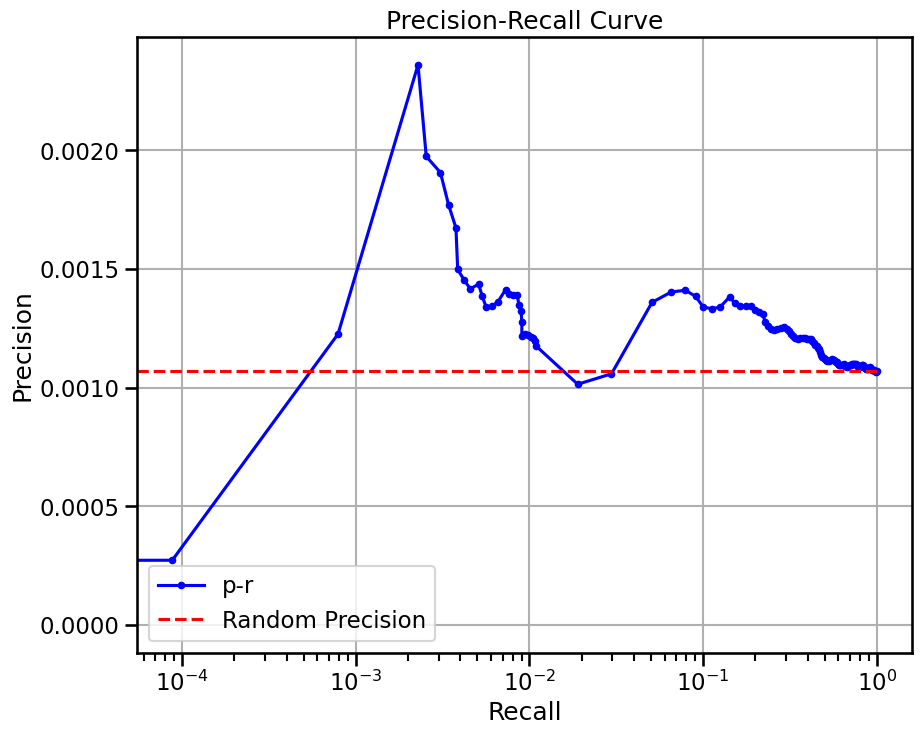

base enrichment


Top central genes: []


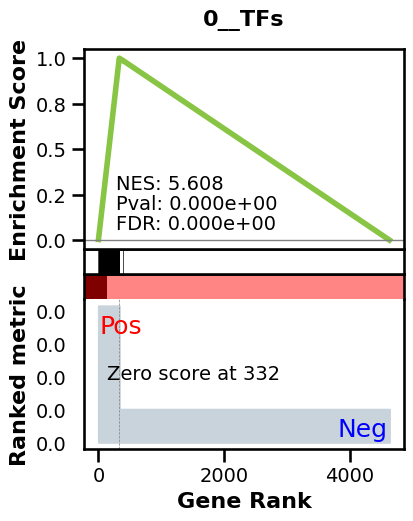

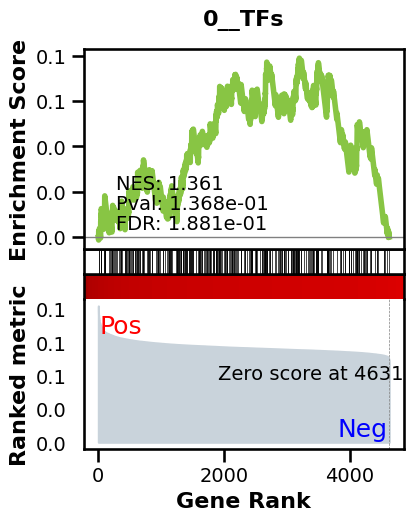

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3263 genes
intersection pct: 0.7044473229706391
precision:  0.005696606855352156 
recall:  0.46327336551118914 
random precision: 0.001070565636336886



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▌         | 7/128 [00:00<00:01, 68.43it/s]


 11%|█         | 14/128 [00:00<00:01, 68.20it/s]


 16%|█▋        | 21/128 [00:00<00:01, 68.30it/s]


 22%|██▏       | 28/128 [00:00<00:01, 68.43it/s]


 27%|██▋       | 35/128 [00:00<00:01, 68.44it/s]


 33%|███▎      | 42/128 [00:00<00:01, 68.31it/s]


 38%|███▊      | 49/128 [00:00<00:01, 68.31it/s]


 44%|████▍     | 56/128 [00:00<00:01, 68.32it/s]


 49%|████▉     | 63/128 [00:00<00:00, 68.29it/s]


 55%|█████▍    | 70/128 [00:01<00:00, 68.22it/s]


 60%|██████    | 77/128 [00:01<00:00, 68.24it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 68.33it/s]


 71%|███████   | 91/128 [00:01<00:00, 68.32it/s]


 77%|███████▋  | 98/128 [00:01<00:00, 68.38it/s]


 82%|████████▏ | 105/128 [00:01<00:00, 68.41it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 68.33it/s]


 93%|█████████▎| 119/128 [00:01<00:00, 68.32it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 67.85it/s]


100%|██████████| 128/128 [00:01<00:00, 68.18it/s]

Average Precision (AP):  0.004122221190287644
Area Under Precision-Recall Curve (AUPRC):  0.0037537699198665047
EPR: 8.4100792621591


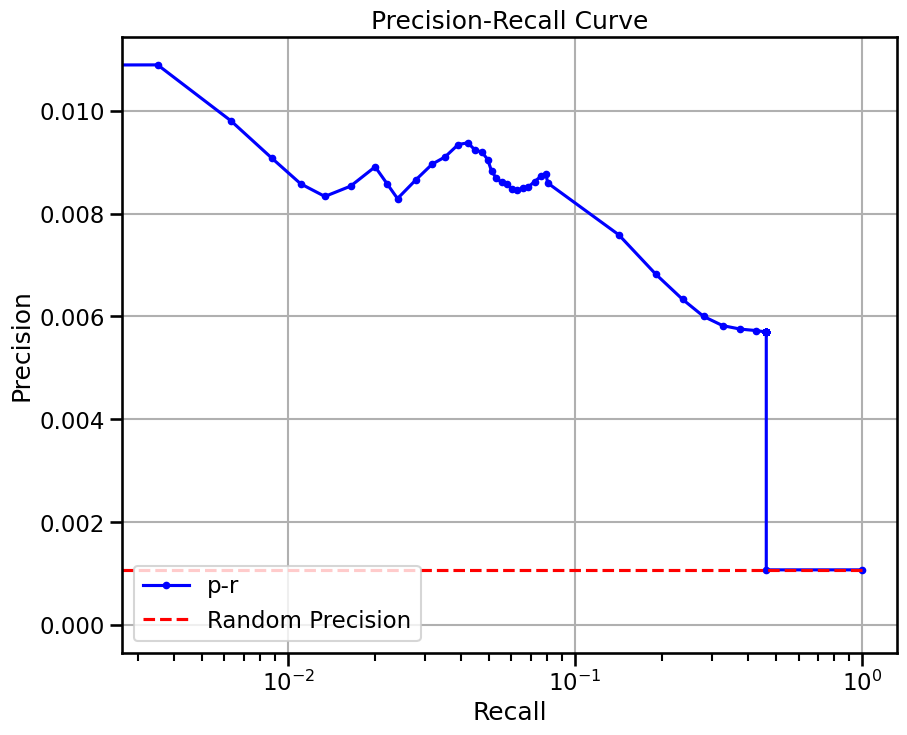

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/52 [00:00<?, ?it/s]


  2%|▏         | 1/52 [00:00<00:19,  2.55it/s]


  4%|▍         | 2/52 [00:00<00:19,  2.53it/s]


  6%|▌         | 3/52 [00:01<00:19,  2.56it/s]


  8%|▊         | 4/52 [00:01<00:18,  2.58it/s]


 10%|▉         | 5/52 [00:01<00:18,  2.59it/s]


 12%|█▏        | 6/52 [00:02<00:17,  2.59it/s]


 13%|█▎        | 7/52 [00:02<00:17,  2.59it/s]


 15%|█▌        | 8/52 [00:03<00:16,  2.60it/s]


 17%|█▋        | 9/52 [00:03<00:16,  2.60it/s]


 19%|█▉        | 10/52 [00:03<00:16,  2.60it/s]


 21%|██        | 11/52 [00:04<00:15,  2.60it/s]


 23%|██▎       | 12/52 [00:04<00:15,  2.60it/s]


 25%|██▌       | 13/52 [00:05<00:14,  2.60it/s]


 27%|██▋       | 14/52 [00:05<00:14,  2.60it/s]


 29%|██▉       | 15/52 [00:05<00:14,  2.60it/s]


 31%|███       | 16/52 [00:06<00:13,  2.60it/s]


 33%|███▎      | 17/52 [00:06<00:13,  2.60it/s]


 35%|███▍      | 18/52 [00:06<00:13,  2.60it/s]


 37%|███▋      | 19/52 [00:07<00:12,  2.60it/s]


 38%|███▊      | 20/52 [00:07<00:12,  2.59it/s]


 40%|████      | 21/52 [00:08<00:11,  2.59it/s]


 42%|████▏     | 22/52 [00:08<00:11,  2.59it/s]


 44%|████▍     | 23/52 [00:08<00:11,  2.60it/s]


 46%|████▌     | 24/52 [00:09<00:10,  2.60it/s]


 48%|████▊     | 25/52 [00:09<00:10,  2.60it/s]


 50%|█████     | 26/52 [00:10<00:10,  2.60it/s]


 52%|█████▏    | 27/52 [00:10<00:09,  2.60it/s]


 54%|█████▍    | 28/52 [00:10<00:09,  2.60it/s]


 56%|█████▌    | 29/52 [00:11<00:08,  2.58it/s]


 58%|█████▊    | 30/52 [00:11<00:08,  2.59it/s]


 60%|█████▉    | 31/52 [00:11<00:08,  2.59it/s]


 62%|██████▏   | 32/52 [00:12<00:07,  2.59it/s]


 63%|██████▎   | 33/52 [00:12<00:07,  2.59it/s]


 65%|██████▌   | 34/52 [00:13<00:06,  2.60it/s]


 67%|██████▋   | 35/52 [00:13<00:06,  2.60it/s]


 69%|██████▉   | 36/52 [00:13<00:06,  2.60it/s]


 71%|███████   | 37/52 [00:14<00:05,  2.60it/s]


 73%|███████▎  | 38/52 [00:14<00:05,  2.57it/s]


 75%|███████▌  | 39/52 [00:15<00:05,  2.58it/s]


 77%|███████▋  | 40/52 [00:15<00:04,  2.58it/s]


 79%|███████▉  | 41/52 [00:15<00:04,  2.59it/s]


 81%|████████  | 42/52 [00:16<00:03,  2.59it/s]


 83%|████████▎ | 43/52 [00:16<00:03,  2.59it/s]


 85%|████████▍ | 44/52 [00:16<00:03,  2.59it/s]


 87%|████████▋ | 45/52 [00:17<00:02,  2.59it/s]


 88%|████████▊ | 46/52 [00:17<00:02,  2.60it/s]


 90%|█████████ | 47/52 [00:18<00:01,  2.60it/s]


 92%|█████████▏| 48/52 [00:18<00:01,  2.60it/s]


 94%|█████████▍| 49/52 [00:18<00:01,  2.60it/s]


 96%|█████████▌| 50/52 [00:19<00:00,  2.60it/s]


 98%|█████████▊| 51/52 [00:19<00:00,  2.59it/s]


100%|██████████| 52/52 [00:19<00:00,  2.76it/s]


100%|██████████| 52/52 [00:19<00:00,  2.60it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


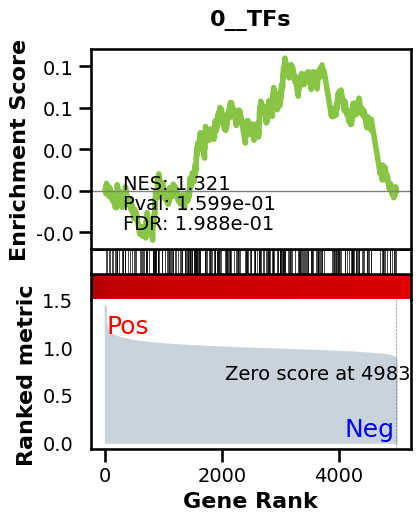

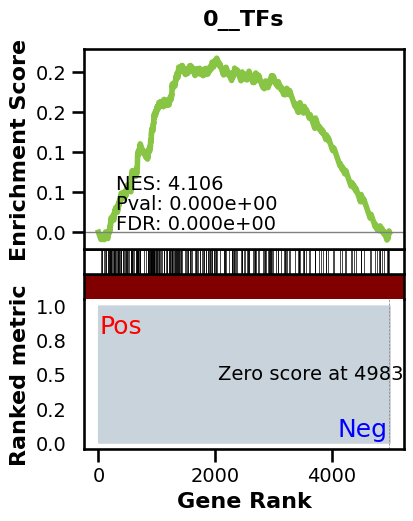

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3462 genes
intersection pct: 0.6946227929373997
precision:  0.001147892393473283 
recall:  1.0 
random precision: 0.0011482240584237233



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 59.65it/s]


  9%|▉         | 12/128 [00:00<00:01, 59.70it/s]


 14%|█▍        | 18/128 [00:00<00:01, 59.83it/s]


 19%|█▉        | 24/128 [00:00<00:01, 59.76it/s]


 23%|██▎       | 30/128 [00:00<00:01, 59.68it/s]


 28%|██▊       | 36/128 [00:00<00:01, 59.67it/s]


 33%|███▎      | 42/128 [00:00<00:01, 59.62it/s]


 38%|███▊      | 48/128 [00:00<00:01, 59.59it/s]


 42%|████▏     | 54/128 [00:00<00:01, 59.42it/s]


 47%|████▋     | 60/128 [00:01<00:01, 59.41it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 59.47it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 59.55it/s]


 61%|██████    | 78/128 [00:01<00:00, 59.57it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 59.57it/s]


 70%|███████   | 90/128 [00:01<00:00, 59.43it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 59.50it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 59.49it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 59.56it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 59.61it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 59.70it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 59.56it/s]


100%|██████████| 128/128 [00:02<00:00, 59.55it/s]

Average Precision (AP):  0.0013031955442876148
Area Under Precision-Recall Curve (AUPRC):  0.0013012685065754486
EPR: 0.2527739283226534


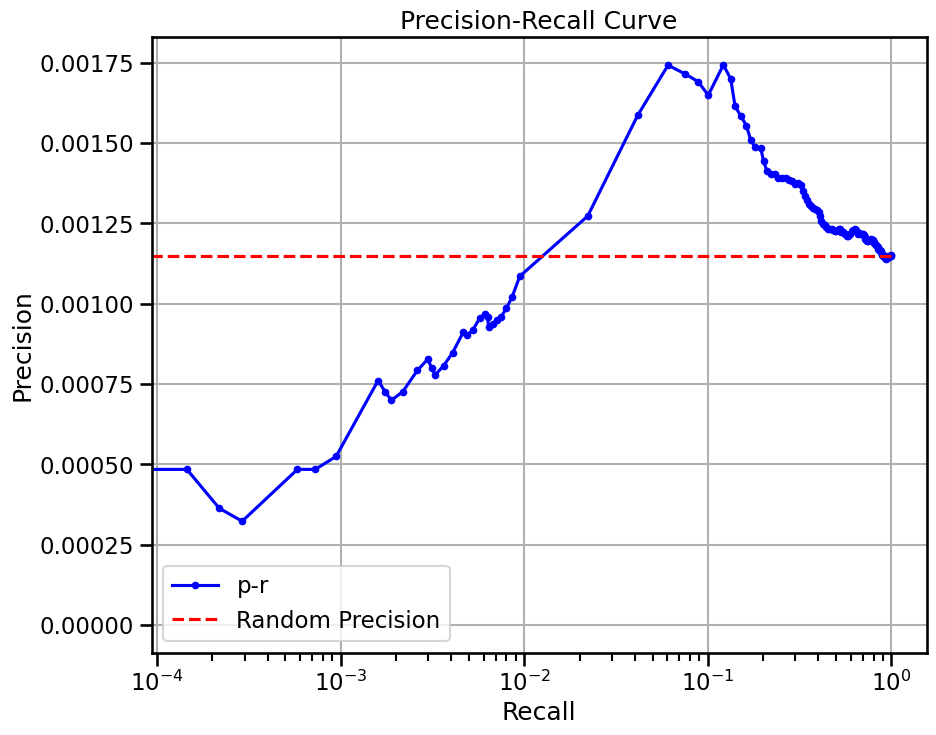

base enrichment


Top central genes: []


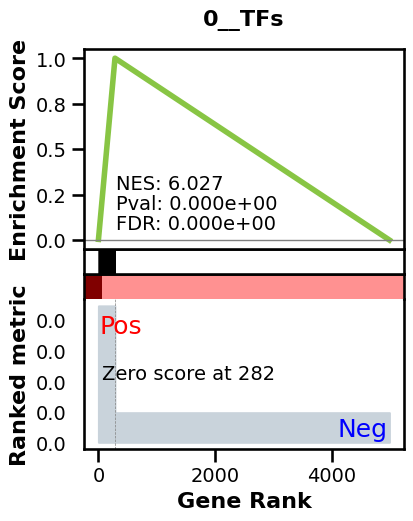

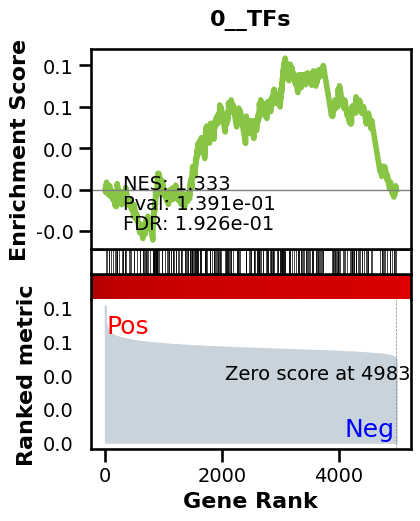

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3462 genes
intersection pct: 0.6946227929373997
precision:  0.0060353289841390614 
recall:  0.3736008140718128 
random precision: 0.0011482240584237233



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 58.40it/s]


  9%|▉         | 12/128 [00:00<00:01, 58.60it/s]


 14%|█▍        | 18/128 [00:00<00:01, 58.79it/s]


 19%|█▉        | 24/128 [00:00<00:01, 58.84it/s]


 23%|██▎       | 30/128 [00:00<00:01, 58.83it/s]


 28%|██▊       | 36/128 [00:00<00:01, 58.71it/s]


 33%|███▎      | 42/128 [00:00<00:01, 58.63it/s]


 38%|███▊      | 48/128 [00:00<00:01, 58.64it/s]


 42%|████▏     | 54/128 [00:00<00:01, 58.71it/s]


 47%|████▋     | 60/128 [00:01<00:01, 58.73it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 58.81it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 58.83it/s]


 61%|██████    | 78/128 [00:01<00:00, 58.80it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 58.84it/s]


 70%|███████   | 90/128 [00:01<00:00, 58.82it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 58.83it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 58.81it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 58.79it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 58.70it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 58.70it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 58.68it/s]


100%|██████████| 128/128 [00:02<00:00, 58.73it/s]

Average Precision (AP):  0.004077083860811816
Area Under Precision-Recall Curve (AUPRC):  0.0036073062308955776
EPR: 8.82750026988658


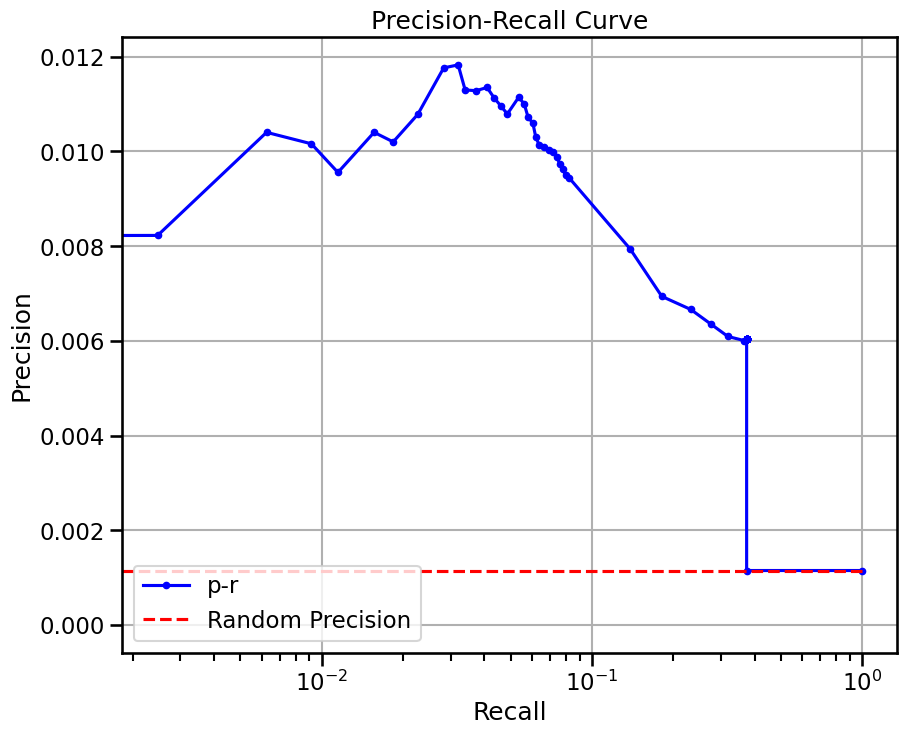

In [6]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
shapes = []
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype].tolist()
    to_use = [i for i in to_use if i in genes]
    to_use = to_use[:NUM_GENES]
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(to_use)]
    print(celltype, subadata.shape)
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 5, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()
    shapes.append(grn.shape[1])
    gc.collect()
    torch.cuda.empty_cache()


In [7]:
metrics

{'scGPT_fibroblast': {'enriched_terms_Regulators': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Adipose progenitor cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Beta cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Alveolar macrophages',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Basal cells (Airway progenitor cells)',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Neutrophils',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Melanocytes'],
  'TF_enr': True,
  'enriched_terms_Targets': ['0__TFs'],
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0013238268130996498,
  'recall': 1.0,
  'rand_precision': 0.0013243138722656173,
  'auprc': 0.001661603514128192,
  'ap': 0.0016622839894261062,
  'epr': 3.4948276601816497},
 'scGPT_tf_fibroblast': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Embryonic stem cells',
   'celltype

In [ ]:
shapes

In [8]:
# taking top 10 only
True
True
True
True
True
True
False
False
False
False
True
False
False
False
# 4 / 7 else 6/7

NameError: name 'T' is not defined

In [2]:
import pandas as pd

In [3]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,fibroblast,3.494828,0.001662,0.001324,0.0,True,False
1,fibroblast,9.464806,0.007200,0.001324,0.0,True,True
2,endothelial cell,0.513450,0.001899,0.001711,0.0,True,False
3,endothelial cell,5.908801,0.004754,0.001711,0.0,True,True
4,myofibroblast cell,1.734585,0.000758,0.000622,0.0,True,False
5,myofibroblast cell,7.277067,0.001082,0.000622,0.0,True,True
6,glial cell,0.000000,0.001175,0.000987,0.0,True,False
7,glial cell,6.551009,0.002602,0.000987,0.0,True,True
8,pericyte,0.364599,0.001316,0.001170,0.0,True,False
9,pericyte,7.035251,0.003992,0.001170,0.0,True,True
